# Investigating Urban–Rural Variability in Fire Department Response Times

In [292]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [293]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [294]:
#read original data
data=pd.read_excel('/content/drive/MyDrive/DI_501/2023-yili-yangin-mudahale-istatistigi.xlsx')
#convert data to csv for better compatibility
data.to_csv('/content/drive/MyDrive/DI_501/2023-yili-yangin-mudahale-istatistigi.csv',index=False)
df=pd.read_csv('/content/drive/MyDrive/DI_501/2023-yili-yangin-mudahale-istatistigi.csv')
df.columns = [x.lower().replace(' ', '_') for x in data.columns]
df.columns = [col.replace('i̇', 'i') for col in df.columns]
df.describe()
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12986 entries, 0 to 12985
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   tarih                                     12986 non-null  object 
 1   yangin_turu                               12986 non-null  object 
 2   yangin_sebebi                             12986 non-null  object 
 3   yangin_sonucu                             12986 non-null  object 
 4   yapi_sekli                                3116 non-null   object 
 5   erkek_vefat                               12986 non-null  int64  
 6   kadin_vefat                               12986 non-null  int64  
 7   itfaiyeci_vefat                           12986 non-null  int64  
 8   erkek_yarali                              12986 non-null  int64  
 9   kadin_yarali                              12986 non-null  int64  
 10  itfaiyeci_yarali                  

,0
tarih,365
yangin_turu,46
yangin_sebebi,31
yangin_sonucu,3
yapi_sekli,7
erkek_vefat,3
kadin_vefat,2
itfaiyeci_vefat,2
erkek_yarali,7
kadin_yarali,5


In this part the main characteristics of the data is investigated to decide on what type of processing will be needed before starting the analysis. The results have shown that VARIS_SURESI (DAK.) - which is the target variable for our analysis -  and EKIPLERİN_CIKIS_SAATI variables are object type.

In [295]:
#type conversion and formatting in the target column
df['varis_suresi_(dak.)'] = df['varis_suresi_(dak.)'].astype(str)
df['varis_suresi_(dak.)'] = df['varis_suresi_(dak.)'].str.replace('00:', '', regex=False)
df['varis_suresi_(dak.)'] = pd.to_numeric(df['varis_suresi_(dak.)'], errors='coerce')
df['varis_suresi_(dak.)'] = df['varis_suresi_(dak.)'].astype('Int64')
#type conversion of other variables
df['ekiplerin_cikis_saati'] = pd.to_datetime(df['ekiplerin_cikis_saati'], format='%H:%M', errors='coerce')
print(df.dtypes)
df.columns.to_list()

tarih                                               object
yangin_turu                                         object
yangin_sebebi                                       object
yangin_sonucu                                       object
yapi_sekli                                          object
erkek_vefat                                          int64
kadin_vefat                                          int64
itfaiyeci_vefat                                      int64
erkek_yarali                                         int64
kadin_yarali                                         int64
itfaiyeci_yarali                                     int64
buyuk_bas_vefat                                      int64
kucuk_bas_vefat                                      int64
kumes_hayvani_vefat                                  int64
evcil_hayvan_vefat                                   int64
diger_hayvan                                         int64
varis_suresi_(dak.)                                  Int

['tarih',
 'yangin_turu',
 'yangin_sebebi',
 'yangin_sonucu',
 'yapi_sekli',
 'erkek_vefat',
 'kadin_vefat',
 'itfaiyeci_vefat',
 'erkek_yarali',
 'kadin_yarali',
 'itfaiyeci_yarali',
 'buyuk_bas_vefat',
 'kucuk_bas_vefat',
 'kumes_hayvani_vefat',
 'evcil_hayvan_vefat',
 'diger_hayvan',
 'varis_suresi_(dak.)',
 'kullanilan_kopuk_miktari_(kg)',
 'kullanilan_su_miktari_(m³)',
 'kullanilan_kuru_kimyevi_toz_miktari_(kg)',
 'ekiplerin_cikis_saati',
 'ilce',
 'adres_bolgesi']

To streamline the analysis and reduce unnecessary dimensionality, certain variables have been aggregated. Highly granular features such as erkek_vefat and kadin_vefat have been combined into a single variable, sivil_vefat, as gender-specific patterns are not within the scope of this study. Whereas the other continuous variables such as  'kullanilan_kopuk_miktari_(kg)', 'kullanilan_su_miktari_(m³)',
 'kullanilan_kuru_kimyevi_toz_miktari_(kg)',  might indicate the severity of the fire and might affect the required response time. This aggregation improves computational efficiency, simplifies interpretation, and aligns the dataset structure with the overarching research objectives.

In [296]:
#combine necessary columns

df['sivil_vefat'] = df['erkek_vefat'] + df['kadin_vefat']
df['hayvan_vefat'] = (df['buyuk_bas_vefat'] + df['kucuk_bas_vefat'] +
                     df['kumes_hayvani_vefat'] + df['evcil_hayvan_vefat'] +
                     df['diger_hayvan'])
df['toplam_vefat'] = df['sivil_vefat'] + df['itfaiyeci_vefat'] + df['hayvan_vefat']
#drop the aggregated columns for sivil_vefat and hayvan_vefat
df.drop(columns=['erkek_vefat', 'kadin_vefat', 'buyuk_bas_vefat', 'kucuk_bas_vefat',
                 'kumes_hayvani_vefat', 'evcil_hayvan_vefat', 'diger_hayvan'], inplace=True)
# Aggregate civilian injuries, animal injuries, and total injuries similarly
df['sivil_yarali'] = df['erkek_yarali'] + df['kadin_yarali']
df['toplam_yarali'] = df['sivil_yarali'] + df['itfaiyeci_yarali']
#drop the aggregated columns for sivil_yarali
df.drop(columns=['erkek_yarali', 'kadin_yarali'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12986 entries, 0 to 12985
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   tarih                                     12986 non-null  object        
 1   yangin_turu                               12986 non-null  object        
 2   yangin_sebebi                             12986 non-null  object        
 3   yangin_sonucu                             12986 non-null  object        
 4   yapi_sekli                                3116 non-null   object        
 5   itfaiyeci_vefat                           12986 non-null  int64         
 6   itfaiyeci_yarali                          12986 non-null  int64         
 7   varis_suresi_(dak.)                       12975 non-null  Int64         
 8   kullanilan_kopuk_miktari_(kg)             12986 non-null  float64       
 9   kullanilan_su_miktari_(m³)  

In [297]:
df.nunique()

,0
tarih,365
yangin_turu,46
yangin_sebebi,31
yangin_sonucu,3
yapi_sekli,7
itfaiyeci_vefat,2
itfaiyeci_yarali,4
varis_suresi_(dak.),60
kullanilan_kopuk_miktari_(kg),47
kullanilan_su_miktari_(m³),113


The number of unique values in each column has been examined to identify potential candidates for conversion to categorical data types, particularly among those initially classified as object. This step is crucial for distinguishing between truly textual data and variables that represent discrete categories, enabling more efficient storage and appropriate treatment in further analyses.

In [298]:
# the unique values are searched to see the categories under candidate object types
df['adres_bolgesi'].unique()

array(['KENT MERKEZİ', 'KIRSAL BÖLGE', 'İL DIŞI'], dtype=object)

Since this analysis focuses on the urban–rural comparison, the records labeled as 'İL DIŞI' are not relevant to the study area and will therefore should be excluded from the analysis.

In [299]:
df = df.loc[df['adres_bolgesi'] != 'İL DIŞI']

In [300]:
#confirm that the values are removes
df['adres_bolgesi'].value_counts()

,count
adres_bolgesi,
KENT MERKEZİ,9577
KIRSAL BÖLGE,3403


In [301]:
df['yapi_sekli'].unique()

array(['BETONARME', nan, 'ÇELİK', 'DİĞER', 'KAGİR', 'AHŞAP', 'ÇELİK-SİL',
       'DİĞER-SİL'], dtype=object)

In [302]:
#removing the misleading celik-sil and diger-sil values
df['yapi_sekli'] = df['yapi_sekli'].replace({'ÇELİK-SİL': 'ÇELİK','DİĞER-SİL': 'DİĞER'})

<ipython-input-302-076ef00bcc63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yapi_sekli'] = df['yapi_sekli'].replace({'ÇELİK-SİL': 'ÇELİK','DİĞER-SİL': 'DİĞER'})


In [303]:
df['yangin_sonucu'].unique()

array(['BAŞLANGIÇTA SÖNDÜRÜLEN', 'KISMEN YANARAK KURTARILAN',
       'TAMAMEN YANAN'], dtype=object)

In [304]:
df['yangin_sebebi'].unique()

array(['KIVILCIM(BACA)', 'SİGARA/KİBRİT', 'ŞÜPHELİ', 'KAZA SONUCU',
       'İHMAL/DİKKATSİZLİK', 'ELEKT. KISA DEV./ELEKT. KONTAĞI',
       'AÇIK ATEŞ', 'PARLAMA (AKARYAKIT MADDESİ)', 'KASIT',
       'ORMAN İTF. TESPİT EDECEK', 'KIVILCIM(DİĞER)',
       'PARLAMA (YAĞ/KİMYASAL MAD.)', 'ÇOCUKLARIN ATEŞLE OYNAMASI',
       'OCAK/SOBA/KALORİFER KAZANI',
       'KONDÜKSİYON (TEMAS İLE ISI TRANSFERİ)', 'ISINMA/SÜRTÜNME',
       'STATİK ELEKTRİK', 'LPG/DOĞALGAZ', 'KUNDAKLAMA/SABOTAJ',
       'RADYASYON (IŞINIM İLE ISI TRANSFERİ)', 'DİĞER', 'HARARET',
       'KONVEKSİYON (HAVA İLE ISI TRANSFERİ)', 'KIZIŞMA',
       'DOĞAL OLAYLAR (YILDIRIM/GÜNEŞ VB)', 'OCAK ÜSTÜ YEMEK UNUTMA',
       'KONTROLLÜ ATEŞİN YANGINA DÖNÜŞMESİ', 'KİMYASAL MADDE REAKSİYONU',
       'İNFİLAK', 'TESPİT EDİLEMEDİ', 'PATLAYICI MADDE'], dtype=object)

Additionally 31 categories in yangin_sebebi carries too much information forthe analysis increasing the complexity. Therefore these values will be aggregated before encoding.

In [305]:
# Define new aggreagetd categorries
yangin_sebebi_cat = {
    'SİGARA/KİBRİT': 'İHMAL',
    'İHMAL/DİKKATSİZLİK': 'İHMAL',
    'ÇOCUKLARIN ATEŞLE OYNAMASI': 'İHMAL',
    'OCAK ÜSTÜ YEMEK UNUTMA': 'İHMAL',
    'KUNDAKLAMA/SABOTAJ': 'İHMAL',
    'KONTROLLÜ ATEŞİN YANGINA DÖNÜŞMESİ': 'İHMAL',
    'KASIT': 'İHMAL',
    'ELEKT. KISA DEV./ELEKT. KONTAĞI': 'ELEKTRİK',
    'STATİK ELEKTRİK': 'ELEKTRİK',
    'KIVILCIM(BACA)': 'ISI',
    'KIVILCIM(DİĞER)': 'ISI',
    'ISINMA/SÜRTÜNME': 'ISI',
    'HARARET': 'ISI',
    'KIZIŞMA': 'ISI',
    'KONDÜKSİYON (TEMAS İLE ISI TRANSFERİ)': 'ISI',
    'RADYASYON (IŞINIM İLE ISI TRANSFERİ)': 'ISI',
    'KONVEKSİYON (HAVA İLE ISI TRANSFERİ)': 'ISI',
    'PARLAMA (AKARYAKIT MADDESİ)': 'YANICI MADDE',
    'PARLAMA (YAĞ/KİMYASAL MAD.)': 'YANICI MADDE',
    'KİMYASAL MADDE REAKSİYONU': 'YANICI MADDE',
    'LPG/DOĞALGAZ': 'YANICI MADDE',
    'PATLAYICI MADDE': 'YANICI MADDE',
    'İNFİLAK': 'YANICI MADDE',
    'DOĞAL OLAYLAR (YILDIRIM/GÜNEŞ VB)': 'DOĞAL NEDEN',
    'ORMAN İTF. TESPİT EDECEK': 'DOĞAL NEDEN',
    'ŞÜPHELİ': 'BİLİNMEYEN',
    'TESPİT EDİLEMEDİ': 'BİLİNMEYEN',
    'DİĞER': 'BİLİNMEYEN',
    'KAZA SONUCU': 'BİLİNMEYEN',
    'OCAK/SOBA/KALORİFER KAZANI': 'ISITMA',
    'AÇIK ATEŞ': 'ISITMA'
}

# Apply the defined categoreis
df['yangin_sebebi'] = df['yangin_sebebi'].map(yangin_sebebi_cat).fillna('DİĞER')
print(df['yangin_sebebi'].unique())

['ISI' 'İHMAL' 'BİLİNMEYEN' 'ELEKTRİK' 'ISITMA' 'YANICI MADDE'
 'DOĞAL NEDEN']


In [306]:
df['yangin_turu'].unique()


array(['BİNA', 'ÇÖP', 'ARAÇ', 'OT', 'KARGILIK', 'LASTİK',
       'ORMAN/FİDANLIK', 'REKLAM/İŞYERİ TABELASI/PANOSU VB', 'PARK',
       'İŞYERİ', 'KABLO/DİREK-ELEKT/TEL VB', 'FABRİKA/ATÖLYE/İMALATHANE',
       'BARAKA/KULÜBE/YAŞAM KONTEYNERİ', 'ODUNLUK/KÖMÜRLÜK',
       'ODUN/KÖMÜR-AÇIK ALANDA', 'İŞ MAKİNESİ', 'HURDA-AÇIK ALANDA',
       'MOTOSİKLET', 'MAKİLİK/ÇALI', 'TRAFO', 'AÇIK ALAN DEPO',
       'SİGORTA PANO-BİNADAN BAĞIMSIZ', 'BAĞ/BAHÇE', 'AĞAÇ',
       'DAM/AHIR/AĞIL', 'HURDALIK', 'METAN GAZI', 'KÜMES', 'GEMİ/TEKNE',
       'DİĞER', 'EKİN/SAMAN', 'ÜSTGEÇİT ASANSÖRÜ', 'ZEYTİNLİK',
       'İNŞAAT ALANI', 'KIZILAY  BAĞIŞ KUTUSU', 'KERESTE/PALET VB',
       'TAVUK ÇİFTLİĞİ', 'PİKNİK TÜPÜ', 'KERESTE/PALET VB.', 'ANIZ',
       'GÜBRE', 'SERA', 'ARAÇ-TEHLİKELİ MAD TAŞIYAN', 'SANDALYE',
       'DAM/AHIR/AĞIL/AMBAR', 'TREN'], dtype=object)

Similarly with yangin_sebebi, yangin_turu has 46 unique values which increases the complexity. Therefore these values will also be aggregated.

In [307]:
yangin_turu_cat= {'BİNA': 'BİNA',
    'FABRİKA/ATÖLYE/İMALATHANE': 'BİNA',
    'BARAKA/KULÜBE/YAŞAM KONTEYNERİ': 'BİNA',
    'İNŞAAT ALANI': 'BİNA',
    'İŞYERİ': 'BİNA',
    'ODUNLUK/KÖMÜRLÜK': 'BİNA',
    'ÜSTGEÇİT ASANSÖRÜ': 'BİNA',
    'ARAÇ': 'ARAÇ',
    'ARAÇ-TEHLİKELİ MAD TAŞIYAN': 'ARAÇ',
    'TREN': 'ARAÇ',
    'MOTOSİKLET': 'ARAÇ',
    'İŞ MAKİNESİ': 'ARAÇ',
    'GEMİ/TEKNE': 'ARAÇ',
    'ANIZ': 'AÇIK ALAN',
    'ORMAN/FİDANLIK': 'AÇIK ALAN',
    'ZEYTİNLİK': 'AÇIK ALAN',
    'MAKİLİK/ÇALI': 'AÇIK ALAN',
    'BAĞ/BAHÇE': 'AÇIK ALAN',
    'OT': 'AÇIK ALAN',
    'AĞAÇ': 'AÇIK ALAN',
    'SERA': 'AÇIK ALAN',
    'KARGILIK': 'AÇIK ALAN',
    'PARK': 'AÇIK ALAN',
    'EKİN/SAMAN': 'AÇIK ALAN',
    'DAM/AHIR/AĞIL': 'TARIMSAL YAPI',
    'DAM/AHIR/AĞIL/AMBAR': 'TARIMSAL YAPI',
    'KÜMES': 'TARIMSAL YAPI',
    'TAVUK ÇİFTLİĞİ': 'TARIMSAL YAPI',
    'TRAFO': 'ELEKTRİK',
    'SİGORTA PANO-BİNADAN BAĞIMSIZ': 'ELEKTRİK',
    'KABLO/DİREK-ELEKT/TEL VB': 'ELEKTRİK',
    'ÇÖP': 'ATIK / DEPO',
    'AÇIK ALAN DEPO': 'ATIK / DEPO',
    'HURDA-AÇIK ALANDA': 'ATIK / DEPO',
    'HURDALIK': 'ATIK / DEPO',
    'LASTİK': 'YANICI MADDE',
    'KERESTE/PALET VB': 'YANICI MADDE',
    'KERESTE/PALET VB.': 'YANICI MADDE',
    'ODUN/KÖMÜR-AÇIK ALANDA': 'YANICI MADDE',
    'METAN GAZI': 'YANICI MADDE',
    'PİKNİK TÜPÜ': 'YANICI MADDE',
    'GÜBRE': 'YANICI MADDE',
    'REKLAM/İŞYERİ TABELASI/PANOSU VB': 'DİĞER',
    'SANDALYE': 'DİĞER',
    'KIZILAY  BAĞIŞ KUTUSU': 'DİĞER',
    'DİĞER': 'DİĞER'}
df['yangin_turu'] = df['yangin_turu'].map(yangin_turu_cat)
print(df['yangin_turu'].unique())

['BİNA' 'ATIK / DEPO' 'ARAÇ' 'AÇIK ALAN' 'YANICI MADDE' 'DİĞER' 'ELEKTRİK'
 'TARIMSAL YAPI']


In [308]:
#treating datetime variable to reflect the time of the day without exaggerating the midnight(00:00) 23:00 difference
df['cikis_saati'] = pd.to_datetime(df['ekiplerin_cikis_saati']).dt.hour
df['cikis_saati_sin'] = np.sin(2 * np.pi * df['cikis_saati'] / 24)
df['cikis_saati_cos'] = np.cos(2 * np.pi * df['cikis_saati'] / 24)

In [309]:
df['month'] = pd.to_datetime(df['tarih']).dt.month
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

df['season'] = df['month'].apply(season)
df.drop(columns=['tarih', 'month'])

,yangin_turu,yangin_sebebi,yangin_sonucu,yapi_sekli,itfaiyeci_vefat,itfaiyeci_yarali,varis_suresi_(dak.),kullanilan_kopuk_miktari_(kg),kullanilan_su_miktari_(m³),kullanilan_kuru_kimyevi_toz_miktari_(kg),...,adres_bolgesi,sivil_vefat,hayvan_vefat,toplam_vefat,sivil_yarali,toplam_yarali,cikis_saati,cikis_saati_sin,cikis_saati_cos,season
0,BİNA,ISI,BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,0,0,4,0.0,1.0,0.0,...,KENT MERKEZİ,0,0,0,0,0,0,0.000000,1.000000,Winter
1,ATIK / DEPO,İHMAL,BAŞLANGIÇTA SÖNDÜRÜLEN,NaN,0,0,3,0.0,0.5,0.0,...,KENT MERKEZİ,0,0,0,0,0,1,0.258819,0.965926,Winter
2,BİNA,BİLİNMEYEN,BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,0,0,2,0.0,0.0,0.0,...,KENT MERKEZİ,0,0,0,0,0,1,0.258819,0.965926,Winter
3,ARAÇ,BİLİNMEYEN,KISMEN YANARAK KURTARILAN,NaN,0,0,4,0.0,2.0,0.0,...,KENT MERKEZİ,0,0,0,0,0,2,0.500000,0.866025,Winter
4,ARAÇ,İHMAL,BAŞLANGIÇTA SÖNDÜRÜLEN,NaN,0,0,6,0.0,0.4,0.0,...,KENT MERKEZİ,0,0,0,2,2,2,0.500000,0.866025,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12981,ATIK / DEPO,İHMAL,BAŞLANGIÇTA SÖNDÜRÜLEN,NaN,0,0,5,0.0,0.2,0.0,...,KENT MERKEZİ,0,0,0,0,0,22,-0.500000,0.866025,Winter
12982,BİNA,ELEKTRİK,BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,0,0,13,0.0,0.0,0.0,...,KIRSAL BÖLGE,0,0,0,0,0,22,-0.500000,0.866025,Winter
12983,BİNA,ELEKTRİK,BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,0,0,3,0.0,5.0,0.0,...,KENT MERKEZİ,0,0,0,0,0,23,-0.258819,0.965926,Winter
12984,BİNA,ELEKTRİK,BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,0,0,5,0.0,0.0,6.0,...,KIRSAL BÖLGE,0,0,0,0,0,22,-0.500000,0.866025,Winter


Before proceeding with encoding, the missing values in the yapi_sekli variable must be addressed, as encoding methods cannot be applied to null values. These variables are selected for encoding because they are categorical in nature and represent qualitative information (such as building type or fire outcome) that needs to be converted into numerical form to be utilized in machine learning models or statistical tests. Handling missing values first ensures that the encoding process is applied consistently and without error. Since the other variables does not have such situation the encoding could be applied beforehand for yangin_ turu and yangin_sonucu, yangin sebebi if necessary.

<Axes: >

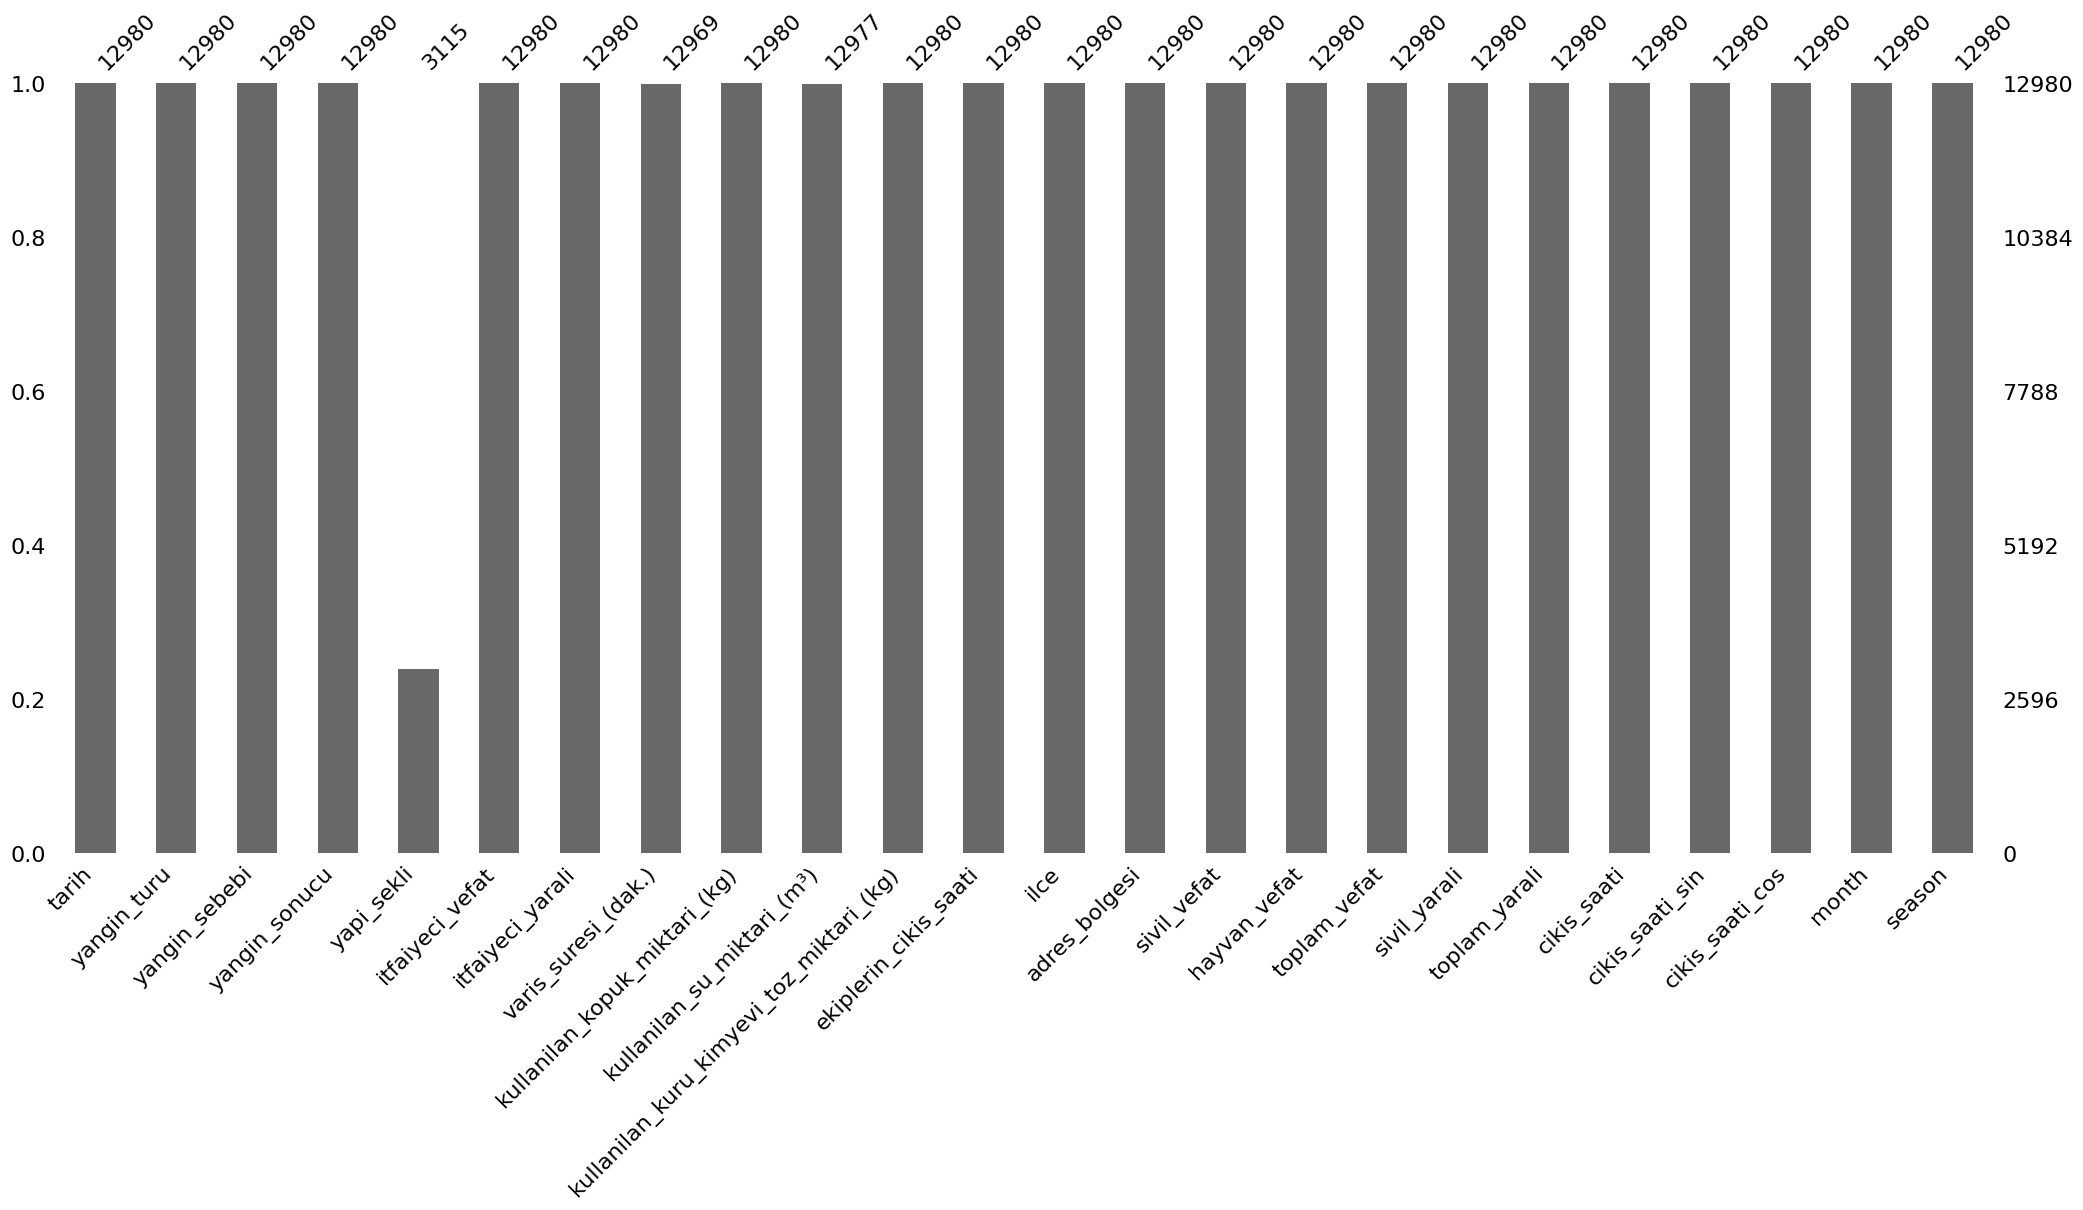

In [310]:
import missingno as msno
msno.bar(df)

<Axes: >

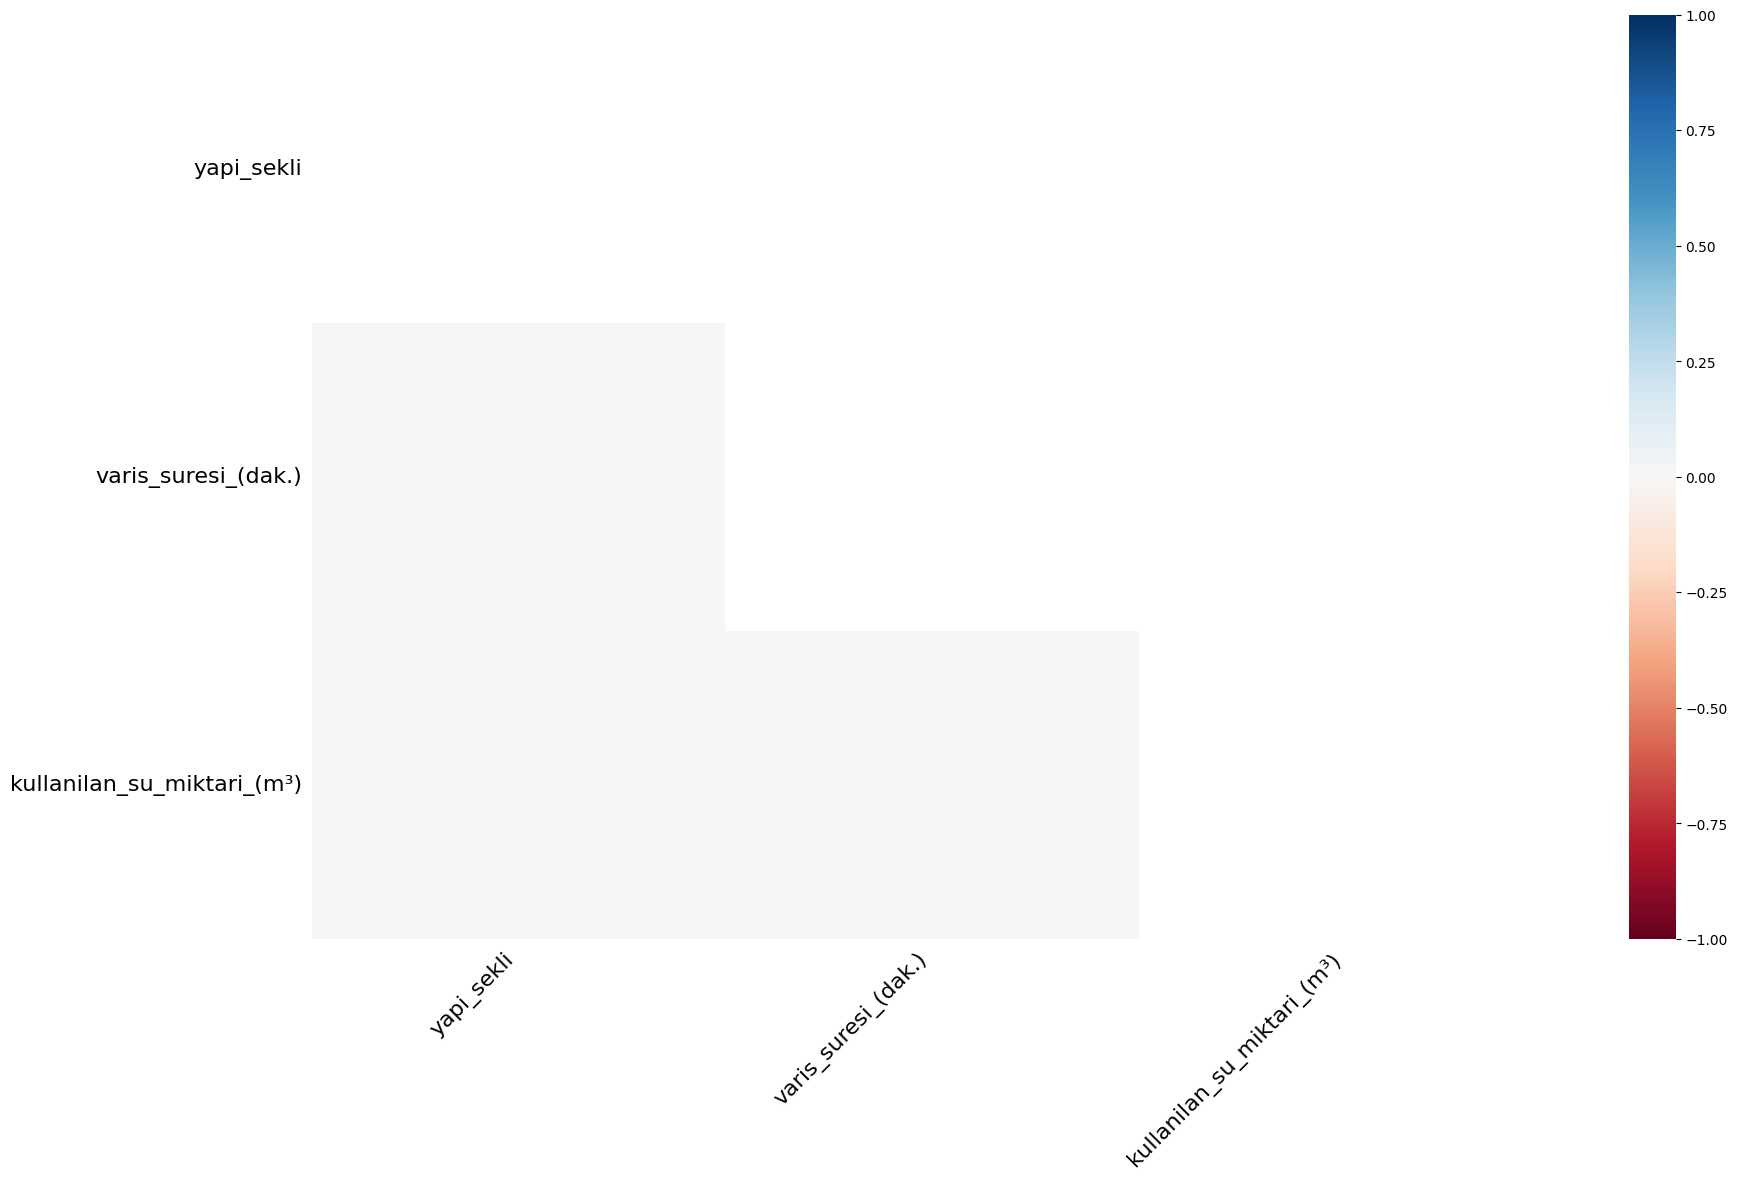

In [311]:
msno.heatmap(df)

The previous analysis indicated that missing values were exclusively found within the yapi_sekli column. Given that a substantial proportion of fire incidents occur in open areas, such as forests or wildlands, it became essential to further investigate the nature of these missing values. Thus, a cross-distribution analysis was conducted between the yapi_sekli and yangin_turu variables to determine whether the observed missingness aligns with categories of fire types. This examination is aided to clarify if the missing data mechanism is Missing Completely at Random (MCAR), Missing at Random (MAR), or Missing Not at Random (MNAR). In addition to yapi_sekli, varis_suresi_(dak.) and kullanilan_su_miktari_(m3) includes some missing values. However, the missingness in thesese variables are limited and occcurs independent from other variables missing completely at random.   

In [312]:
# Identify rows where 'yapi_sekli' is missing corresponds in yangin_turu
df[df['yapi_sekli'].isna()].groupby('yangin_turu').size()

,0
yangin_turu,
ARAÇ,1098
ATIK / DEPO,3203
AÇIK ALAN,4992
BİNA,14
DİĞER,48
ELEKTRİK,360
YANICI MADDE,150


Most of the missing values are places in the categories that are not related to a structure thherefore structure type not being specified is not at random. however there are small number of missingness in structure fire type which is missing independent fromt his deduction.

In [313]:
df.loc[df['yapi_sekli'].isna() & (df['yangin_turu'] != 'BİNA'), 'yapi_sekli'] = 'YAPI DEGIL'

In [314]:
df['yapi_sekli'].isna().sum()

np.int64(14)

In [315]:
df = df.dropna(subset=['varis_suresi_(dak.)', 'kullanilan_su_miktari_(m³)'])

<Axes: >

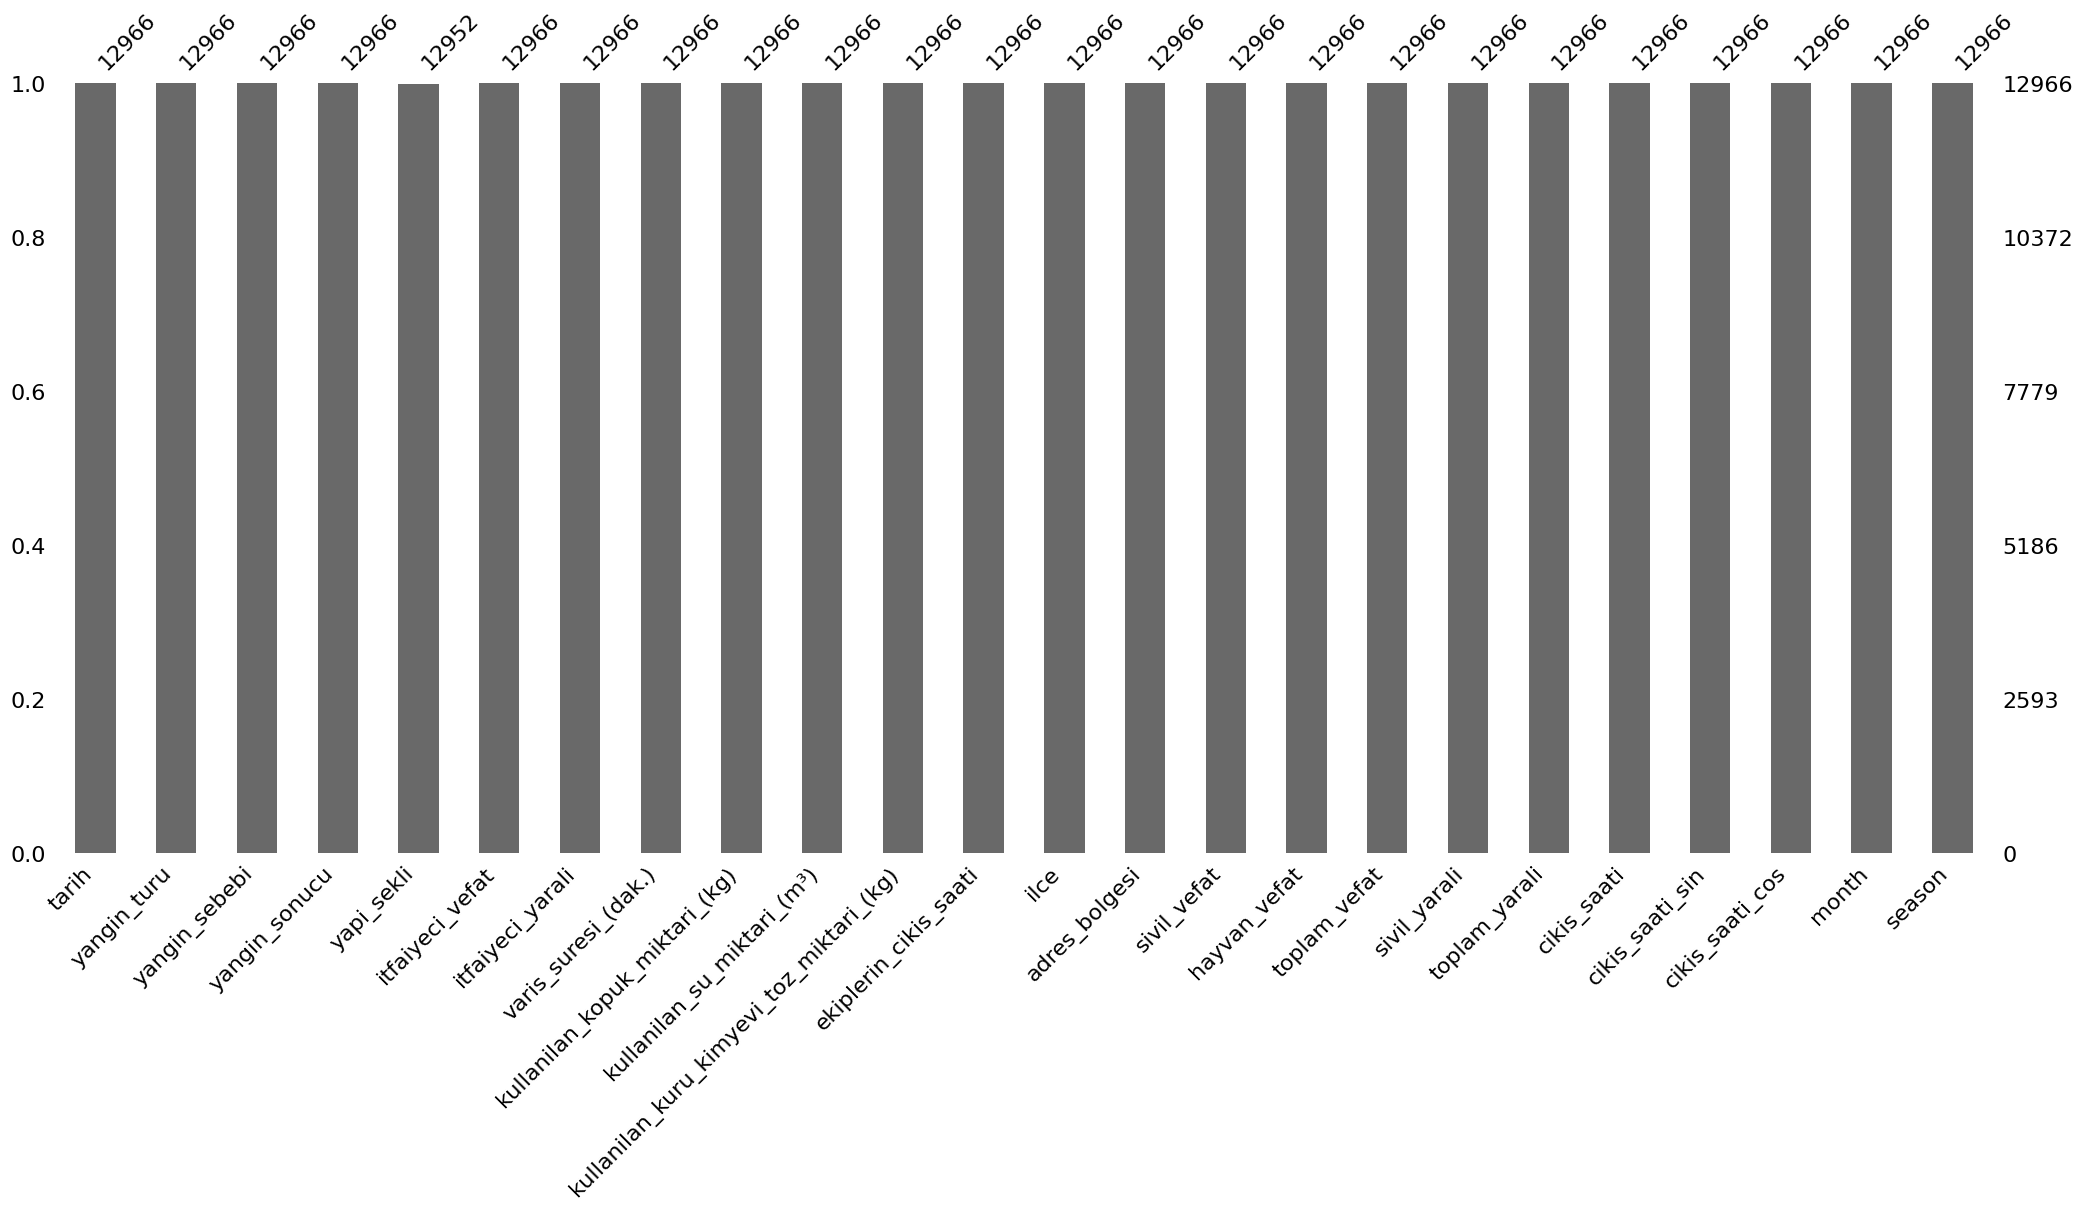

In [316]:
msno.bar(df)

In [317]:
df = df.dropna(subset=['yapi_sekli'])

<Axes: >

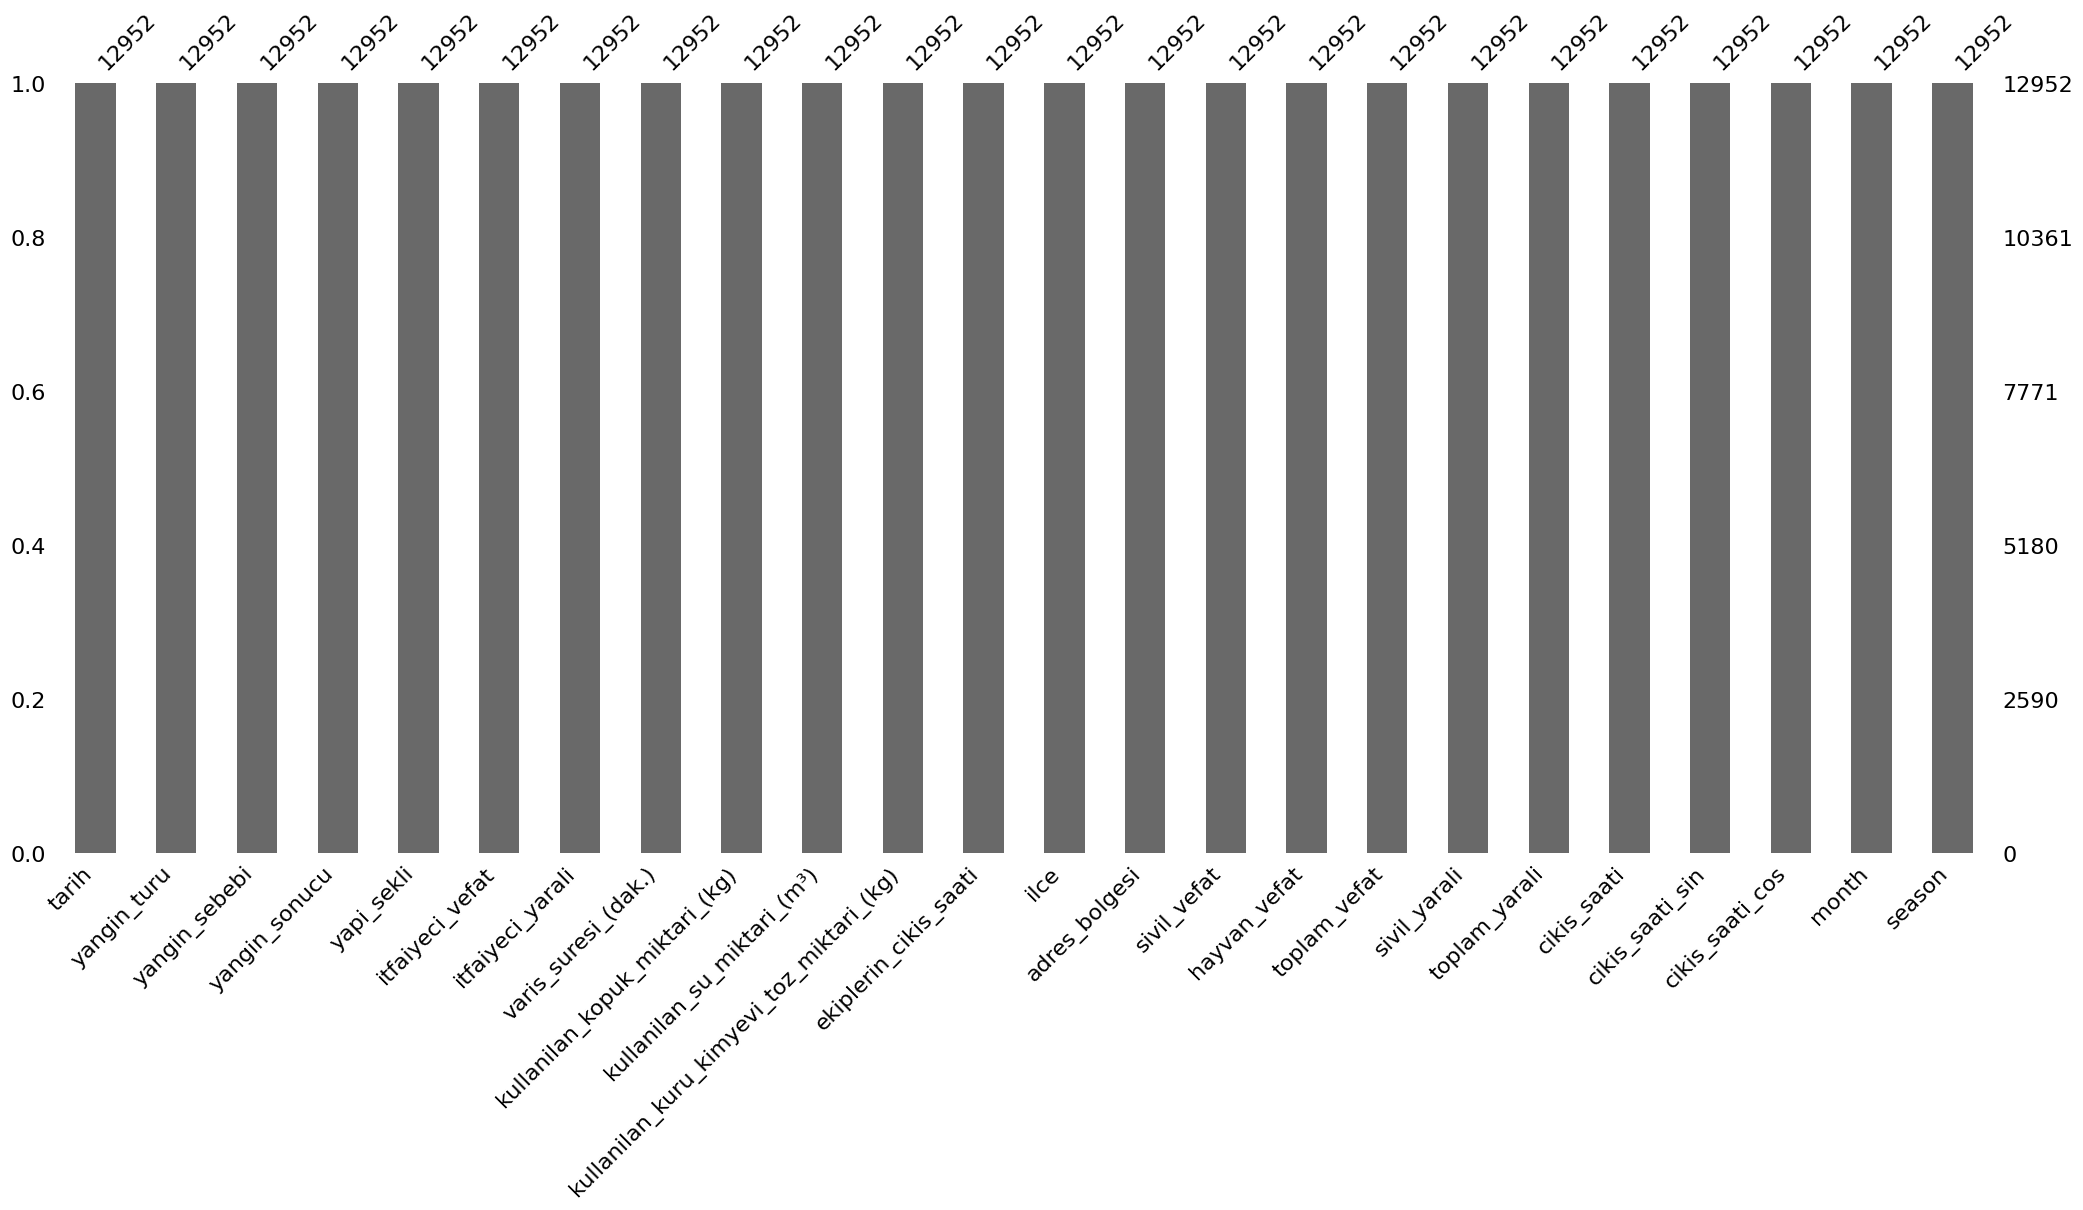

In [318]:
msno.bar(df)

At this point data cleaning and feature engineering parts are completed and the data exploration will be conducted to examine both the overall distributions and the urban–rural breakdown.

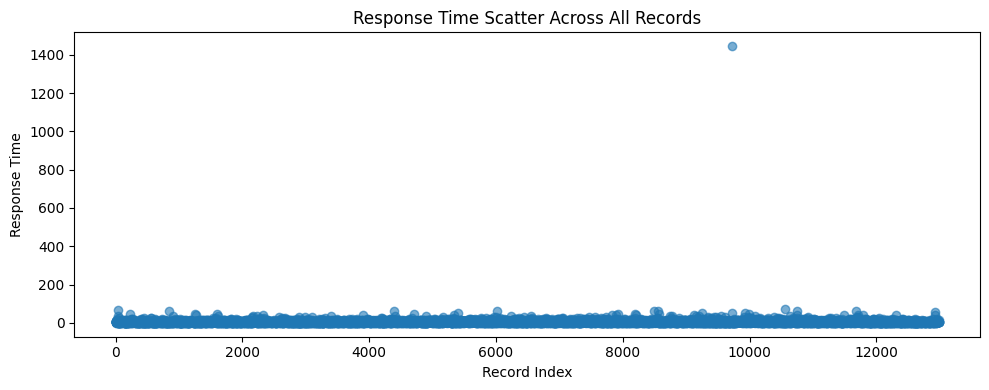

In [319]:
pd.to_numeric(df['varis_suresi_(dak.)'], errors='coerce')

# scatterplot of target variable
##outlier detection
plt.figure(figsize=(10, 4))
plt.scatter(df.index, df['varis_suresi_(dak.)'], alpha=0.6)
plt.title('Response Time Scatter Across All Records')
plt.xlabel('Record Index')
plt.ylabel('Response Time')
plt.tight_layout()
plt.show()


In [320]:
#remove the outlier in the data
df = df.loc[df['varis_suresi_(dak.)'] != 1445]

# 3. Confirm the outlier is gone
print("New max:", df['varis_suresi_(dak.)'].max())

New max: 70


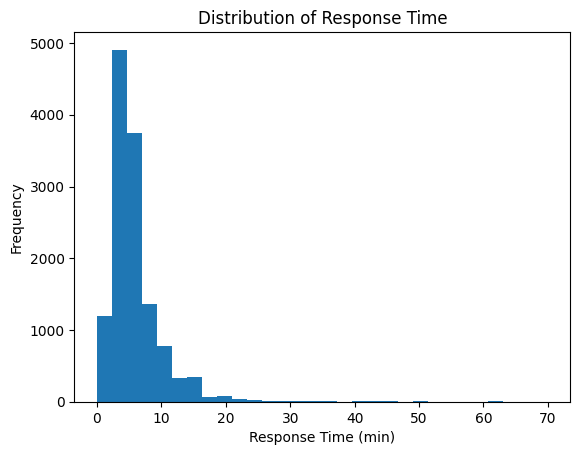

In [321]:
plt.hist(df['varis_suresi_(dak.)'], bins=30)
plt.title('Distribution of Response Time')
plt.xlabel('Response Time (min)')
plt.ylabel('Frequency')
plt.show()

In [322]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_cols].describe())

       itfaiyeci_vefat  itfaiyeci_yarali  varis_suresi_(dak.)  \
count     12951.000000      12951.000000              12951.0   
mean          0.000077          0.001621             5.743958   
std           0.008787          0.053428             4.492164   
min           0.000000          0.000000                  0.0   
25%           0.000000          0.000000                  3.0   
50%           0.000000          0.000000                  5.0   
75%           0.000000          0.000000                  6.0   
max           1.000000          3.000000                 70.0   

       kullanilan_kopuk_miktari_(kg)  kullanilan_su_miktari_(m³)  \
count                   12951.000000                12951.000000   
mean                        5.552402                    3.928877   
std                       158.405859                   24.946216   
min                         0.000000                    0.000000   
25%                         0.000000                    0.200000   
50%   

       itfaiyeci_vefat  itfaiyeci_yarali  varis_suresi_(dak.)  \
count     12951.000000      12951.000000              12951.0   
mean          0.000077          0.001621             5.743958   
std           0.008787          0.053428             4.492164   
min           0.000000          0.000000                  0.0   
25%           0.000000          0.000000                  3.0   
50%           0.000000          0.000000                  5.0   
75%           0.000000          0.000000                  6.0   
max           1.000000          3.000000                 70.0   

       kullanilan_kopuk_miktari_(kg)  kullanilan_su_miktari_(m³)  \
count                   12951.000000                12951.000000   
mean                        5.552402                    3.928877   
std                       158.405859                   24.946216   
min                         0.000000                    0.000000   
25%                         0.000000                    0.200000   
50%   

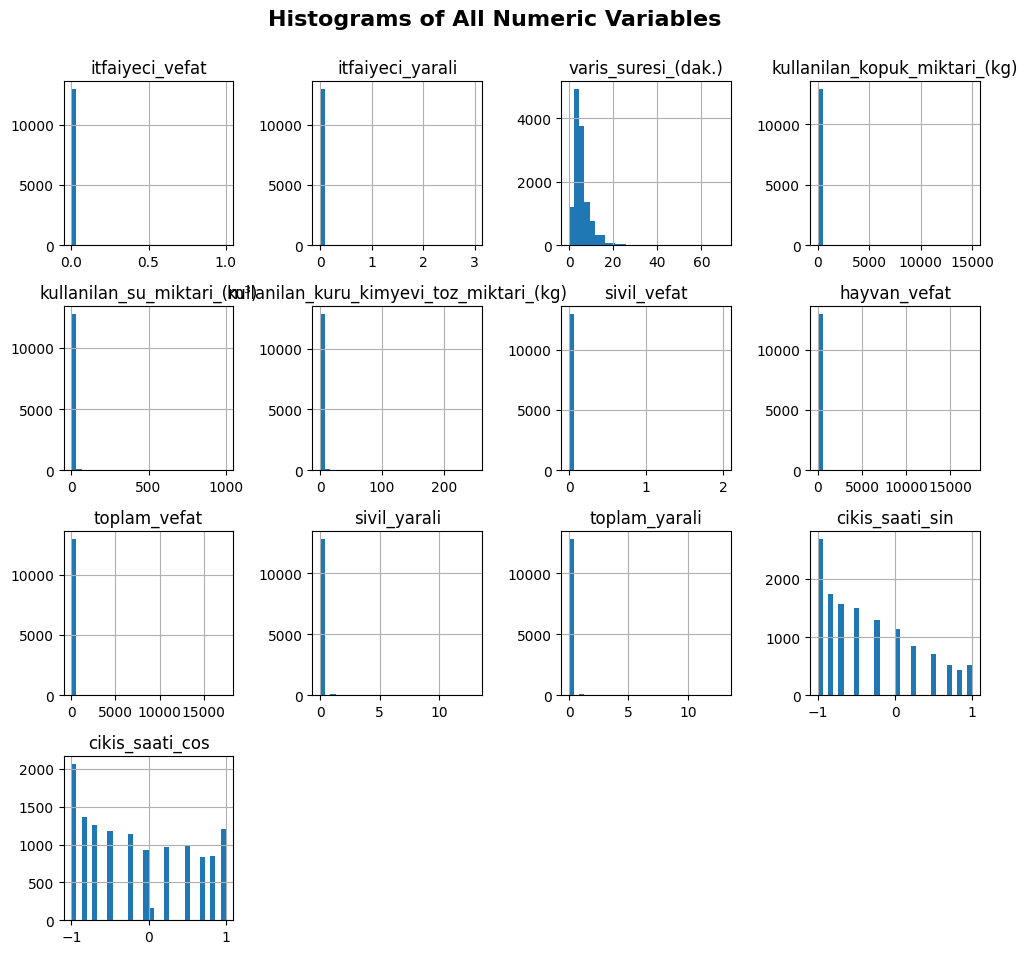

In [323]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_cols].describe())
df[numeric_cols].hist(figsize=(10, 10), bins=30)
plt.suptitle('Histograms of All Numeric Variables', y=0.95, fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.savefig("Histogram_All_Num.png", dpi=300, bbox_inches='tight')
plt.close()

Overall, subplots were used to examine the distribution of numeric variables after the initial preprocessing steps. Most of the variables such as injury, fatality, and chemical usage indicators were observed to be highly sparse, with values mostly concentrated at zero. Additionally, variables like hayvan_vefat, toplam_vefat, and kullanilan_su_miktari_(m³) showed right-skewed distributions with a few extreme outliers. On the other hand, response time (varis_suresi_(dak.)) displayed a more continuous distribution, though still with a right-skewed tail. Based on these patterns, variables such as kullanilan_kuru_kimyevi_toz_miktari_(kg), kullanilan_su_miktari_(m³), kullanilan_kopuk_miktari_(kg)  should be log-transformed to reduce highly skew, response time may benefit from normalization, and sparse variables including toplam_vefat and toplam_yarali can be binary encoded since detailed counts are less relevant for analyzing urban–rural variability in response times.

<ipython-input-324-5b396542810b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='colorblind')
<ipython-input-324-5b396542810b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='colorblind')
<ipython-input-324-5b396542810b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='colorblind')
<ipython-input-324-5b396542810b>:7: FutureWarning: 

Passing `palette` wi

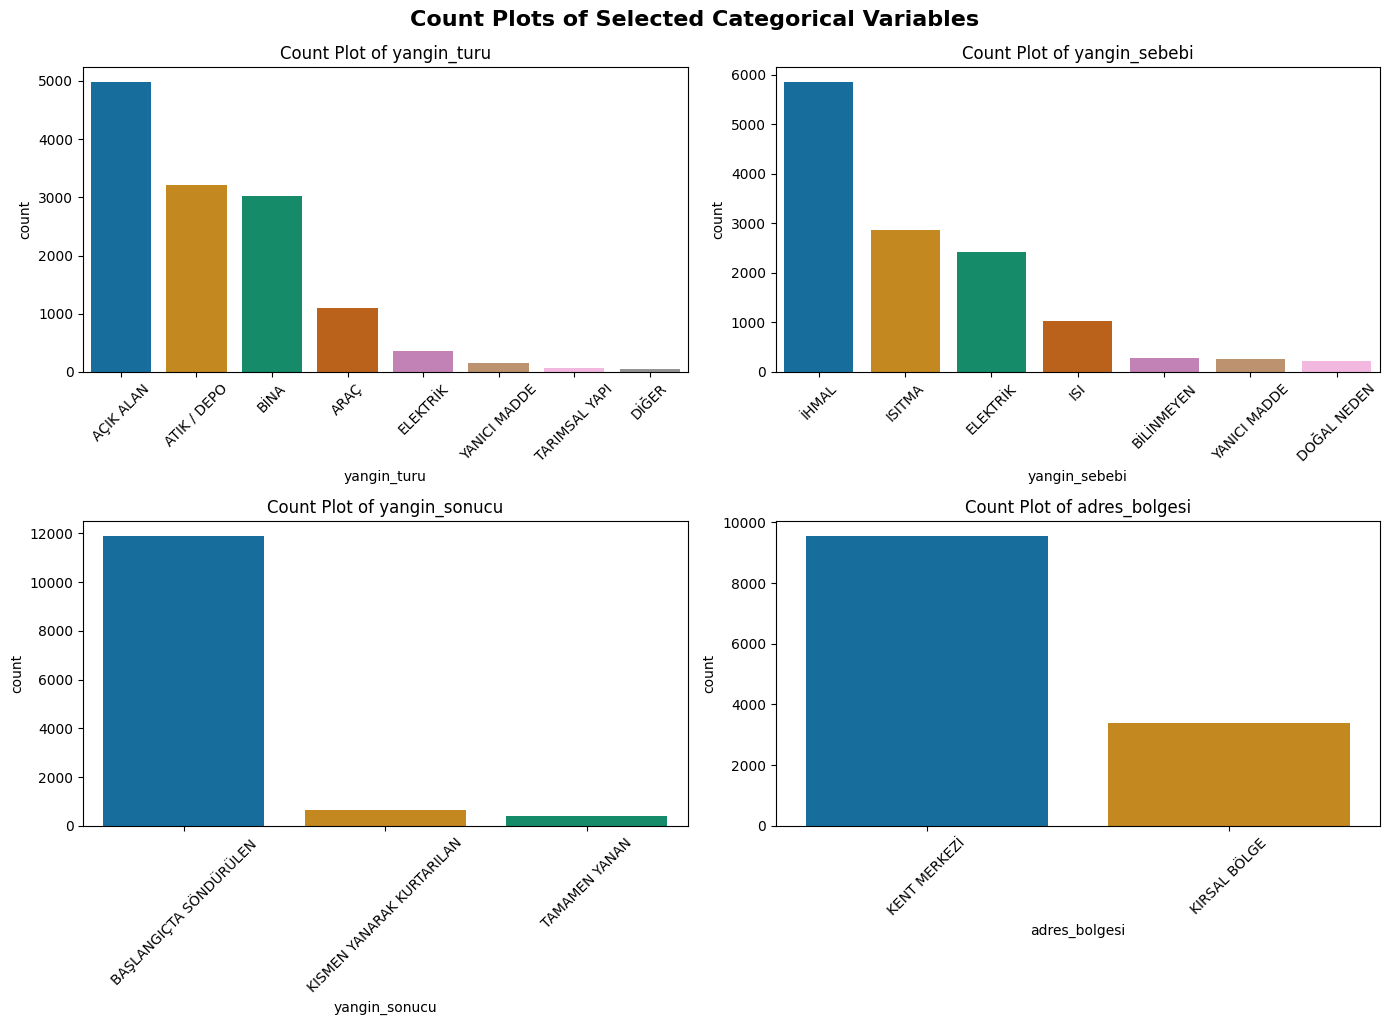

In [324]:
categorical_cols = ['yangin_turu', 'yangin_sebebi', 'yangin_sonucu', 'adres_bolgesi']

plt.figure(figsize=(14, 10))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='colorblind')
    plt.title(f'Count Plot of {col}', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle('Count Plots of Selected Categorical Variables', fontsize=16, fontweight='bold', y=1.02)
plt.show()

 The fire type (yangin_turu) and fire cause (yangin_sebebi) variables showed relatively balanced distributions among a few dominant categories, such as open area fires and negligence, while others appeared much less frequent. The fire outcome (yangin_sonucu) distribution was highly imbalanced, with the majority of cases categorized as “BAŞLANGIÇTA SÖNDÜRÜLEN,” indicating early intervention. In contrast, the adres_bolgesi variable presented a clear urban–rural split, with incidents in urban areas occurring at a much higher rate. As a result only yangin_sonucuplanned to be performed ordinal encoding due to the inherent progression in severity across its categories.

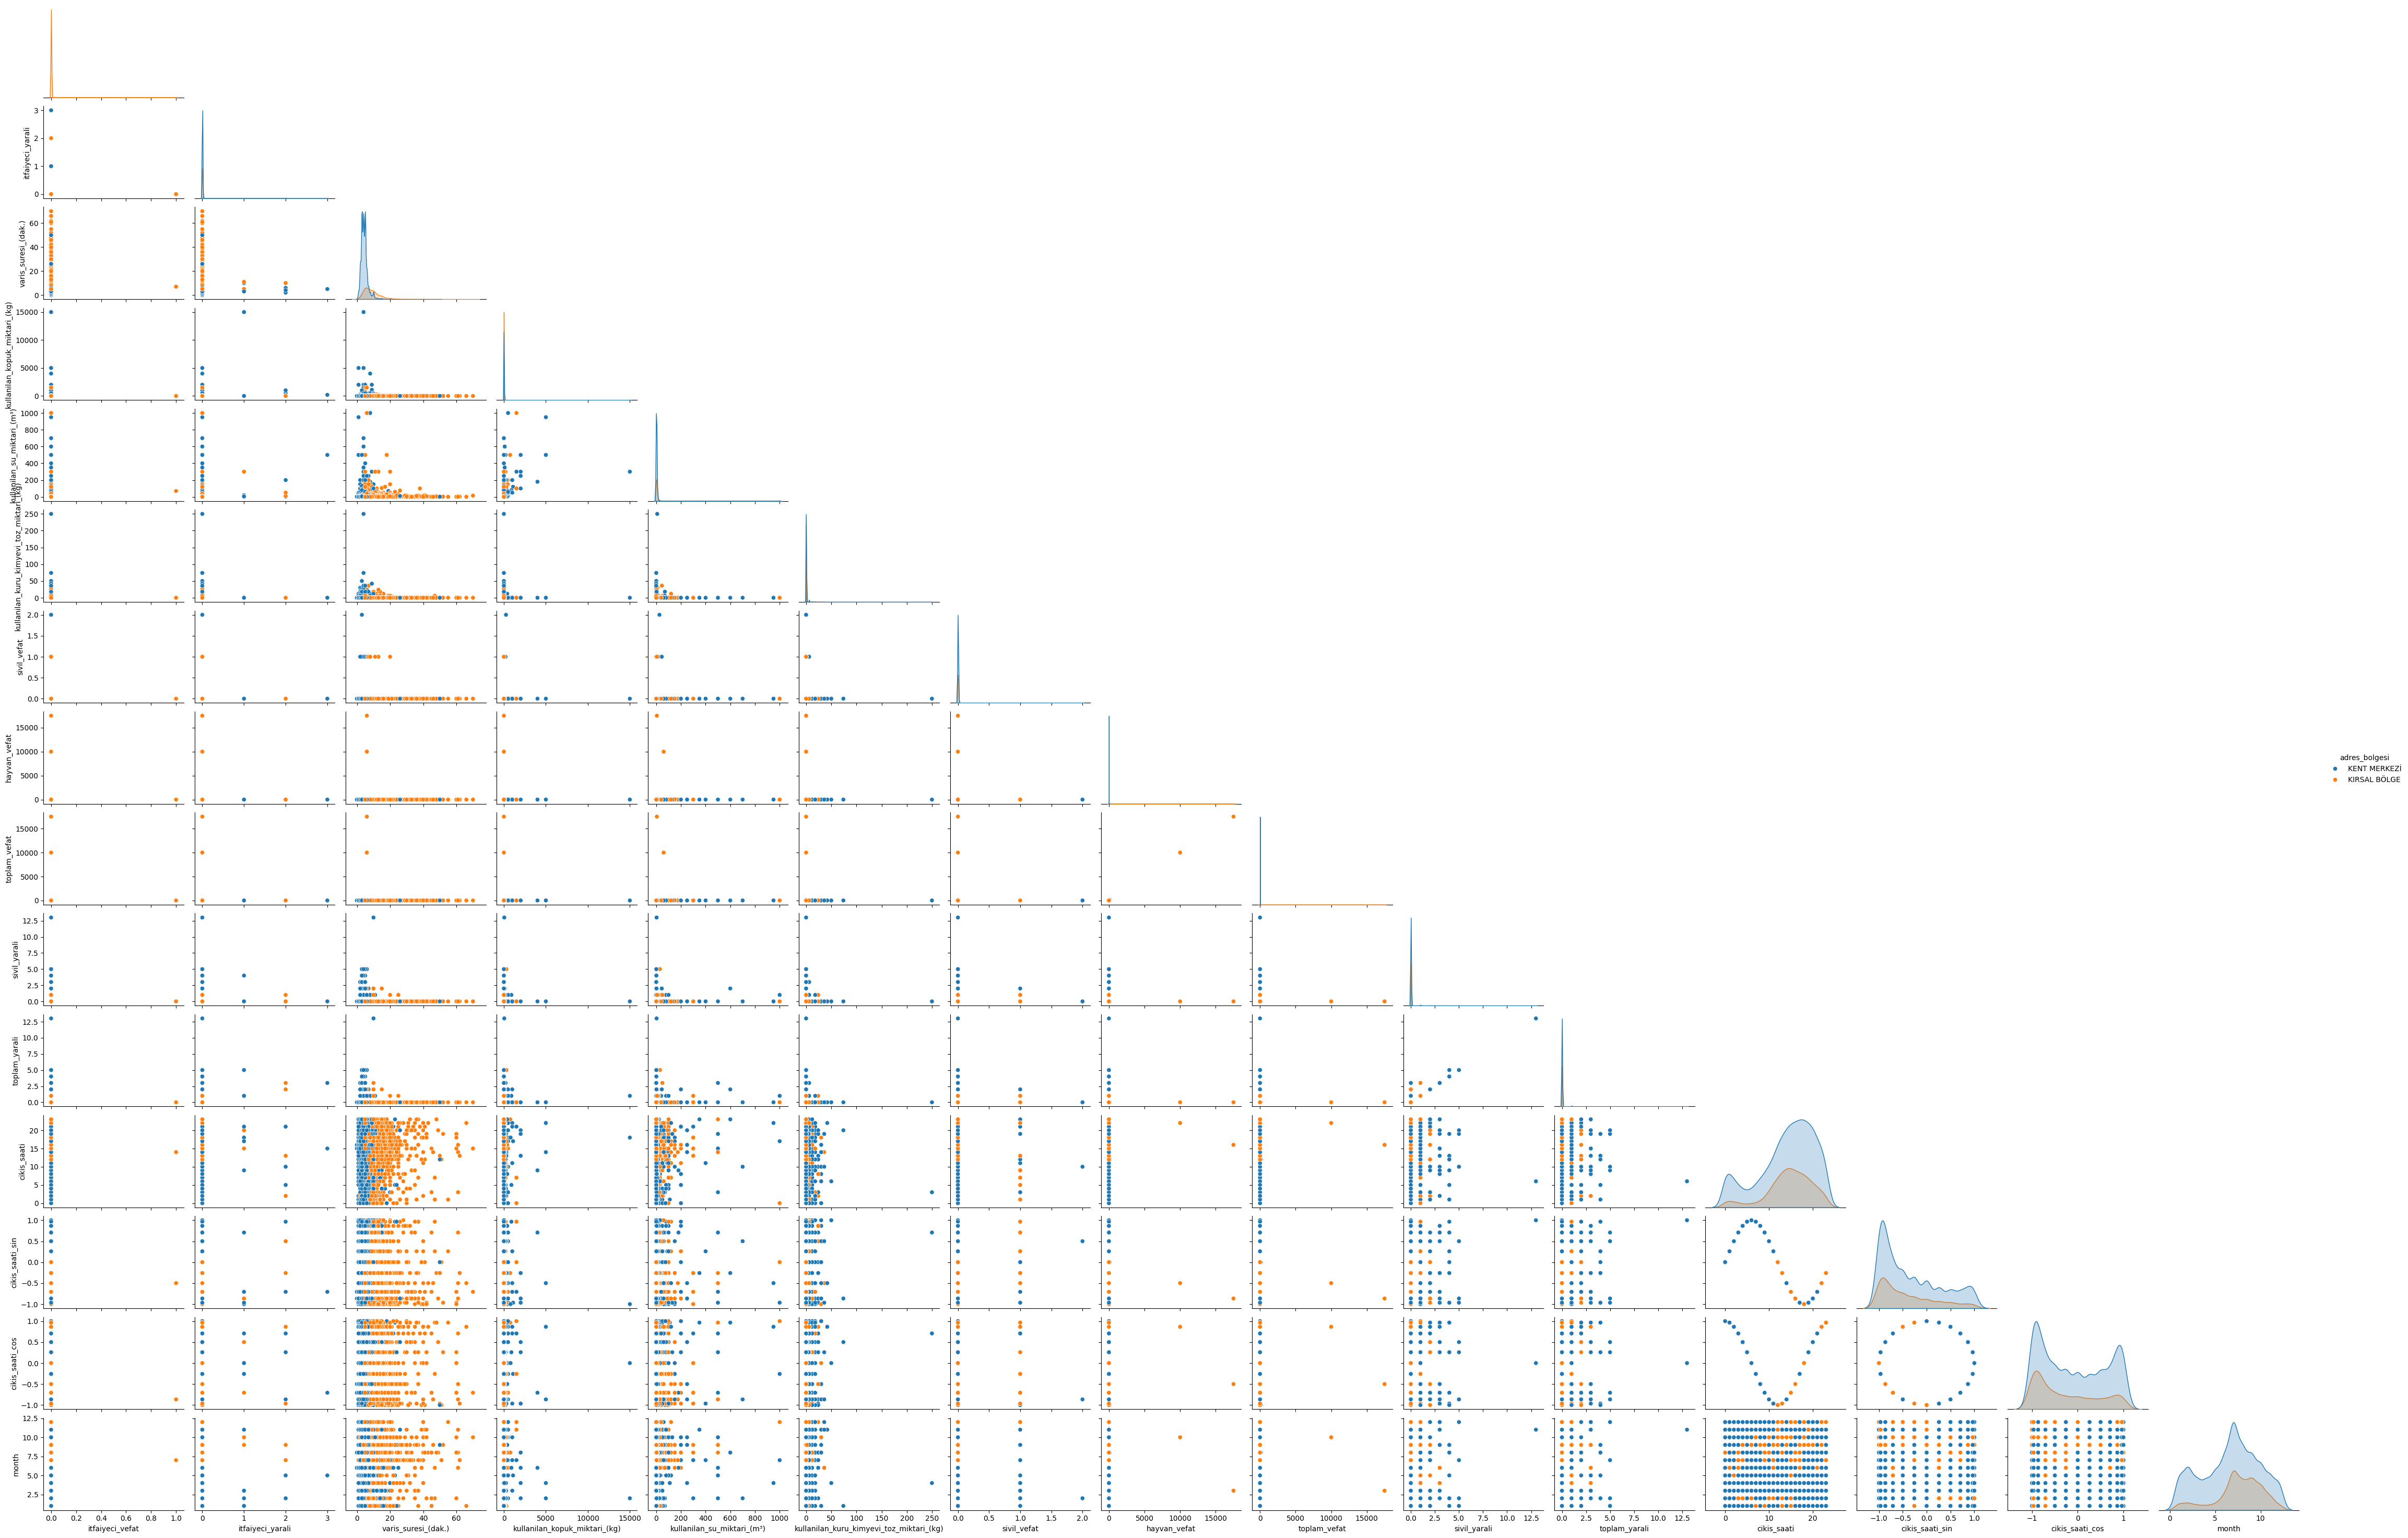

In [325]:
sns.pairplot(df, hue='adres_bolgesi',corner = True, height=2, aspect=1.5);

The scatter plots indicate that fires in rural areas are generally associated with longer response times, suggesting delayed access to incident locations compared to urban settings. Additionally, rural fires tend to require a higher amount of firefighting materials, reflecting potentially greater fire severity or spread. In terms of human impact, rural fires appear to result in more fatalities, while urban fires are more often associated with non-fatal injuries such as bruising or burns.

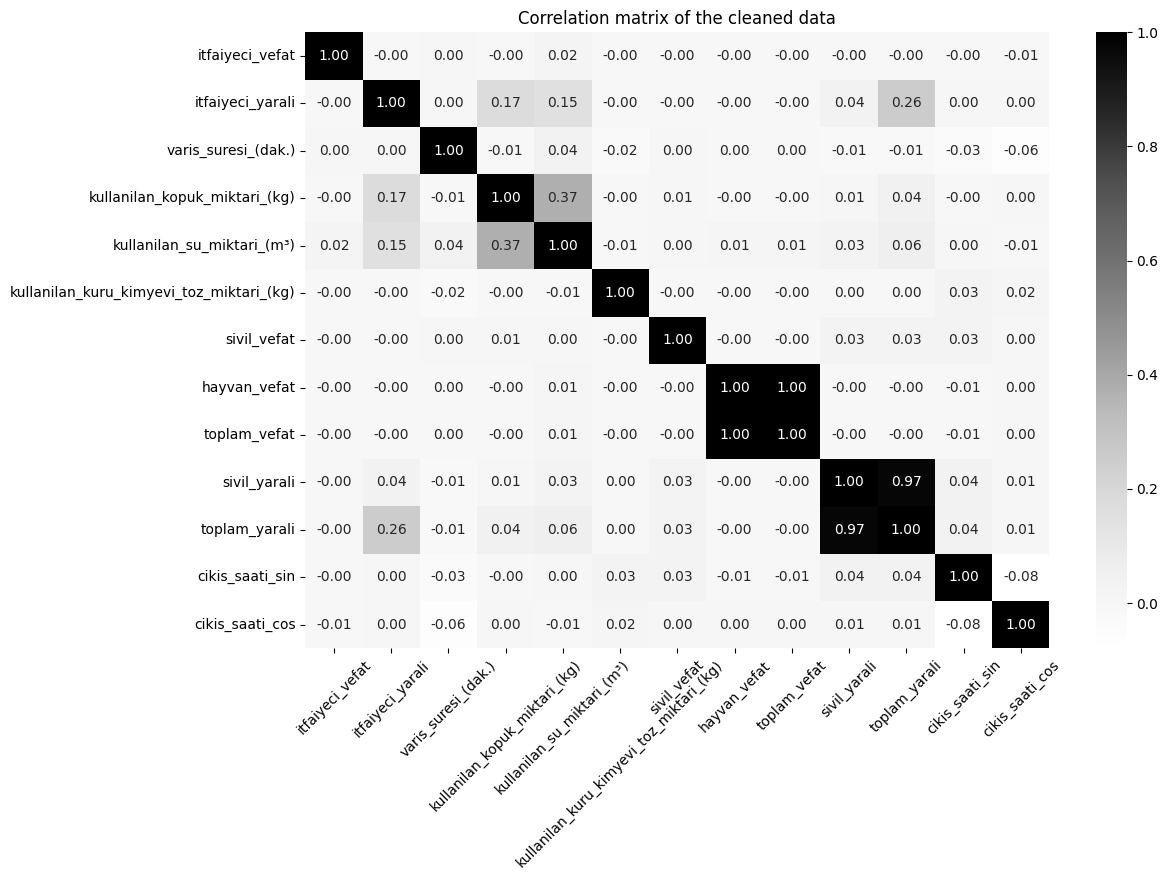

In [326]:
X = df.select_dtypes(include=['int64', 'float64'])

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), xticklabels=X.columns, yticklabels=X.columns, annot=True, fmt='.2f', cmap='Greys')
plt.title('Correlation matrix of the cleaned data')
plt.xticks(rotation=45)
plt.show()

In [327]:
#further analysis to test Is there a significant difference in response times of urban versus rural areas?
#H0: Median response times (urban) = Median response times (rural)
#𝐻𝑎: Median response times (urban) ≠ Median response times (rural)
print((df.groupby('adres_bolgesi')['varis_suresi_(dak.)'].agg(['mean', 'median', 'count'])).round(2))

               mean  median  count
adres_bolgesi                     
KENT MERKEZİ   4.42     4.0   9552
KIRSAL BÖLGE   9.47     8.0   3399


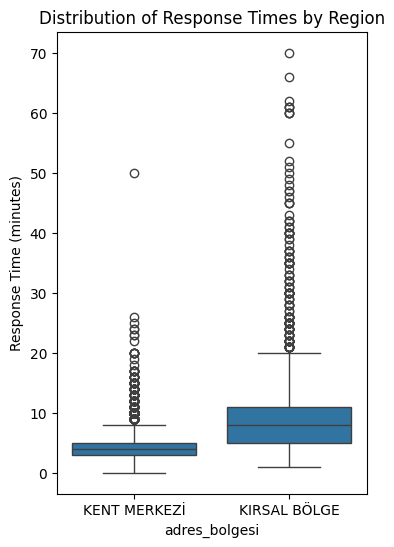

In [328]:
plt.figure(figsize=(4,6))
sns.boxplot(x='adres_bolgesi', y='varis_suresi_(dak.)', data=df)
plt.title("Distribution of Response Times by Region")
plt.ylabel("Response Time (minutes)")
plt.show()
plt.savefig("response_boxplot.png", dpi=300, bbox_inches='tight')
plt.close()

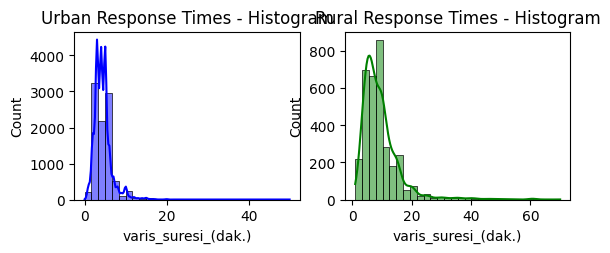

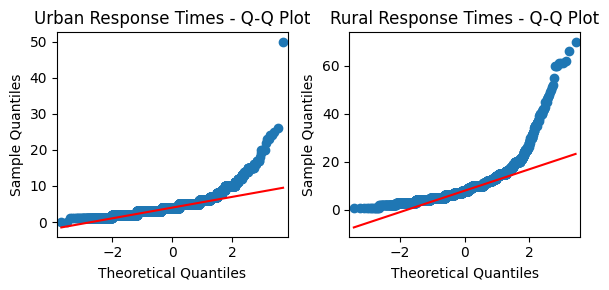

In [329]:
import scipy.stats as stats

# Separate response times by region
urban_times = df[df['adres_bolgesi']=='KENT MERKEZİ']['varis_suresi_(dak.)']
rural_times = df[df['adres_bolgesi']=='KIRSAL BÖLGE']['varis_suresi_(dak.)']
#histogram to test normality  and cariance to check assumptions
plt.subplot(2, 2, 1)
sns.histplot(urban_times, bins=30, kde=True, color='blue')
plt.title('Urban Response Times - Histogram')

plt.subplot(2, 2, 2)
sns.histplot(rural_times, bins=30, kde=True, color='green')
plt.title('Rural Response Times - Histogram')

#Q-Q plot to check normality assumption
import statsmodels.api as sm
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
# Plot Q-Q plots using statsmodels
sm.qqplot(urban_times, line='q', ax=axes[0])
axes[0].set_title('Urban Response Times - Q-Q Plot')

sm.qqplot(rural_times, line='q', ax=axes[1])
axes[1].set_title('Rural Response Times - Q-Q Plot')

plt.tight_layout()
plt.show()

Normality and variance assumptions were examined to inform the test selection. The histograms revealed that both urban and rural response times deviate from a normal distribution, as well as havıng differences in variability between the groups. Q-Q plots further supported the absence of normality. Given these characteristics, the Mann-Whitney U test, considering the test focuses on differences in medians, was identified as the most suitable method for comparing the groups.

In [330]:
from scipy.stats import mannwhitneyu

# Apply the test
result = mannwhitneyu(urban_times, rural_times, alternative='two-sided')

# Output the result
print(f'Mann-Whitney U statistic: {result.statistic}')
print(f'p-value: {result.pvalue:.4f}')

Mann-Whitney U statistic: 5370111.5
p-value: 0.0000


The boxplot and summary statistics already highlight a marked difference in response times between urban and rural areas. The median response time doubles from 4 minutes in urban settings to 8 minutes in rural locations. The difference was formally evaluated using the Mann-Whitney U test. The analysis produced a U statistic of 5,370,111.5 and a p-value of 0.000, leading to the rejection of the null hypothesis. This outcome confirms that the difference in response times is statistically significant, with urban areas exhibiting consistently shorter response times compared to rural areas.

In [331]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
### Applying the required encodings as a result of our data exploration before ML analysis later on
## applying ordinal encodingto the yangin_sonucu column due to the nature of variable/data
# define the order of categories and fit
ordered_categories = [['BAŞLANGIÇTA SÖNDÜRÜLEN','KISMEN YANARAK KURTARILAN','TAMAMEN YANAN']]
oe = OrdinalEncoder(categories=ordered_categories)
df['yangin_sonucu'] = oe.fit_transform(df[['yangin_sonucu']])

In [332]:
#onehot encoding for all the rest of categorical variables
from sklearn.preprocessing import OneHotEncoder

cats = ['yangin_turu', 'yangin_sebebi', 'yapi_sekli','season']

onehot = OneHotEncoder(sparse_output=False)
onehot.fit(df[cats])

encoded = onehot.transform(df[cats])
onehot_df = pd.DataFrame(encoded,columns=onehot.get_feature_names_out(cats),index=df.index)
#combine to dataset
df = pd.concat([df.drop(columns=cats), onehot_df], axis=1)

Although in the earlier steps data aggregation is applied on _vefat and _yarali variables since the data has shown highly sparse in these varaibles  the presence of the condition would be more meaningful than the exact count in the analysis. Therefore binary encoding is applied to these variables.

In [333]:
df['Binary_ToplamVefat'] = (df['toplam_vefat'] > 0).astype(int)
df['Binary_ToplamYarali'] = (df['toplam_yarali'] > 0).astype(int)
#drop encoded source columns
df.drop(columns=['toplam_vefat', 'toplam_yarali'], inplace=True)

In [334]:
df['Log_Kopuk'] = np.log1p(df['kullanilan_kopuk_miktari_(kg)'])
df['Log_Su'] = np.log1p(df['kullanilan_su_miktari_(m³)'])
df['Log_Kimyasal'] = np.log1p(df['kullanilan_kuru_kimyevi_toz_miktari_(kg)'])
print((df[['Log_Kopuk','kullanilan_kopuk_miktari_(kg)', 'Log_Su', 'kullanilan_su_miktari_(m³)','Log_Kimyasal','kullanilan_kuru_kimyevi_toz_miktari_(kg)']]).describe())

          Log_Kopuk  kullanilan_kopuk_miktari_(kg)        Log_Su  \
count  12951.000000                   12951.000000  12951.000000   
mean       0.094271                       5.552402      0.839707   
std        0.645726                     158.405859      0.835192   
min        0.000000                       0.000000      0.000000   
25%        0.000000                       0.000000      0.182322   
50%        0.000000                       0.000000      0.693147   
75%        0.000000                       0.000000      1.098612   
max        9.615872                   15000.000000      6.908755   

       kullanilan_su_miktari_(m³)  Log_Kimyasal  \
count                12951.000000  12951.000000   
mean                     3.928877      0.061304   
std                     24.946216      0.370920   
min                      0.000000      0.000000   
25%                      0.200000      0.000000   
50%                      1.000000      0.000000   
75%                      2.000

Based on the histogram results log transformation is applied to variables with highly skewed distributions to reduce the impact of extreme values and better reveal patterns in the majority of the data. Log transform is preferred compared to other scaling methods due to the the large outliers in the variables.

In [335]:
#final feature selection
redundant_cols=['kullanilan_kopuk_miktari_(kg)','kullanilan_su_miktari_(m³)','kullanilan_kuru_kimyevi_toz_miktari_(kg)','itfaiyeci_vefat', 'itfaiyeci_yarali','sivil_vefat','hayvan_vefat','sivil_yarali','ilce','ekiplerin_cikis_saati','tarih','cikis_saati','month']
df.drop(columns=redundant_cols, inplace=True, errors = "ignore")

As part of feature selection, variables containing sparse or highly skewed raw counts were dropped from the dataset. These include original chemical usage quantities and detailed injury/fatality counts, which were either transformed or binary encoded in earlier steps. Their removal helps reduce redundancy and improves model focus on more meaningful, processed features

In [336]:
df.columns.to_list()

['yangin_sonucu',
 'varis_suresi_(dak.)',
 'adres_bolgesi',
 'cikis_saati_sin',
 'cikis_saati_cos',
 'yangin_turu_ARAÇ',
 'yangin_turu_ATIK / DEPO',
 'yangin_turu_AÇIK ALAN',
 'yangin_turu_BİNA',
 'yangin_turu_DİĞER',
 'yangin_turu_ELEKTRİK',
 'yangin_turu_TARIMSAL YAPI',
 'yangin_turu_YANICI MADDE',
 'yangin_sebebi_BİLİNMEYEN',
 'yangin_sebebi_DOĞAL NEDEN',
 'yangin_sebebi_ELEKTRİK',
 'yangin_sebebi_ISI',
 'yangin_sebebi_ISITMA',
 'yangin_sebebi_YANICI MADDE',
 'yangin_sebebi_İHMAL',
 'yapi_sekli_AHŞAP',
 'yapi_sekli_BETONARME',
 'yapi_sekli_DİĞER',
 'yapi_sekli_KAGİR',
 'yapi_sekli_YAPI DEGIL',
 'yapi_sekli_ÇELİK',
 'season_Autumn',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'Binary_ToplamVefat',
 'Binary_ToplamYarali',
 'Log_Kopuk',
 'Log_Su',
 'Log_Kimyasal']

In [337]:
df_urban = df[df["adres_bolgesi"] == "KENT MERKEZİ"].copy()
df_rural = df[df["adres_bolgesi"] == "KIRSAL BÖLGE"].copy()


Since the next task is to conduct 2nd research question which includes comparing urban and rural, data has been splitted based on these characteristics before moving on further.

In [338]:
#split urban data for train, test and validation
from sklearn.model_selection import train_test_split

#define target and other variable
X_urban = df_urban.drop(columns=['varis_suresi_(dak.)', 'adres_bolgesi'])
y_urban = df_urban['varis_suresi_(dak.)']

#split data into train and test
X_train_u, X_temp_u, y_train_u, y_temp_u = train_test_split(X_urban, y_urban, test_size=0.3, random_state=1908607)

#split again for validation
X_val_u, X_test_u, y_val_u, y_test_u = train_test_split(X_temp_u, y_temp_u, test_size=0.5, random_state=1908607)

In [339]:
#split rural data
X_rural = df_rural.drop(columns=['varis_suresi_(dak.)', 'adres_bolgesi'])
y_rural = df_rural['varis_suresi_(dak.)']

#split data into train and test
X_train_r, X_temp_r, y_train_r, y_temp_r = train_test_split(X_rural, y_rural, test_size=0.3, random_state=1908607)
#split temp into test and val
X_val_r, X_test_r, y_val_r, y_test_r = train_test_split(X_temp_r, y_temp_r, test_size=0.5, random_state=1908607)

In [340]:
#creating the baseline model for urban and rural predictors
from sklearn.metrics import mean_absolute_error

# Urban data baseline
urban_baseline_val = np.mean(y_train_u)
urban_baseline_val_mae = mean_absolute_error(y_val_u, [urban_baseline_val] * len(y_val_u))

# Rural data baseline
rural_baseline_val = np.mean(y_train_r)
rural_baseline_val_mae = mean_absolute_error(y_val_r, [rural_baseline_val] * len(y_val_r))

print("Urban baseline Mean Absolute Error:", urban_baseline_val_mae)
print("Rural baseline Mean Absolute Error:", rural_baseline_val_mae)

Urban baseline Mean Absolute Error: 1.458108609943933
Rural baseline Mean Absolute Error: 4.477304683958493


In [341]:
#testing linear regression assumption against baseline
from sklearn.linear_model import LinearRegression

urban_lr = LinearRegression().fit(X_train_u, y_train_u)
urban_lr_val_pred = urban_lr.predict(X_val_u)
urban_mae = mean_absolute_error(y_val_u, urban_lr_val_pred)
print("Urban LinearRegression Mean Absolute Error:", mean_absolute_error(y_val_u, urban_lr_val_pred))

rural_lr = LinearRegression().fit(X_train_r, y_train_r)
rural_lr_val_pred = rural_lr.predict(X_val_r)
rural_mae = mean_absolute_error(y_val_r, rural_lr_val_pred)
print("Rural LinearRegression Mean Absolute Error:", mean_absolute_error(y_val_r, rural_lr_val_pred))

Urban LinearRegression Mean Absolute Error: 1.409675869438534
Rural LinearRegression Mean Absolute Error: 4.41874305773575


In [342]:
#Testing decisiontree regressor fit on rural data
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Hyperparameter values to tune
max_depth_values = [2, 4, 6,8]
min_leaf_values = [1, 2, 3, 4]

# trying each leaf depth combination
results_rural = []
for max_depth in max_depth_values:
    for min_leaf in min_leaf_values:
        rural_tree_model = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_leaf=min_leaf,
            random_state=1908607)
        rural_tree_model.fit(X_train_r, y_train_r)
        predictions = rural_tree_model.predict(X_val_r)
        mae = mean_absolute_error(y_val_r, predictions)
        results_rural.append({
            'max_depth': max_depth,
            'min_samples_leaf': min_leaf,
            'MAE': mae})

# Convert to DataFrame for ease of representation
import pandas as pd
results_df = pd.DataFrame(results_rural)

# Identify the best hyperparameter configguration
best_params = results_df.loc[results_df['MAE'].idxmin()]
print("Rural results:")
print(results_df)
print("\nRural Best hyperparameters:")
print(best_params)

Rural results:
    max_depth  min_samples_leaf       MAE
0           2                 1  4.478694
1           2                 2  4.478694
2           2                 3  4.478694
3           2                 4  4.478694
4           4                 1  4.470534
5           4                 2  4.482673
6           4                 3  4.530802
7           4                 4  4.526749
8           6                 1  4.554655
9           6                 2  4.566171
10          6                 3  4.587905
11          6                 4  4.519839
12          8                 1  4.850868
13          8                 2  4.712265
14          8                 3  4.705937
15          8                 4  4.614923

Rural Best hyperparameters:
max_depth           4.000000
min_samples_leaf    1.000000
MAE                 4.470534
Name: 4, dtype: float64


In [343]:
#testing decision tree regressor for urban
# trying each leaf depth combination
results_urban = []
for max_depth in max_depth_values:
    for min_leaf in min_leaf_values:
        urban_tree_model = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_leaf=min_leaf,
            random_state=1908607)
        urban_tree_model.fit(X_train_u, y_train_u)
        predictions = urban_tree_model.predict(X_val_u)
        mae = mean_absolute_error(y_val_u, predictions)
        results_urban.append({
            'max_depth': max_depth,
            'min_samples_leaf': min_leaf,
            'MAE': mae})

# Convert to DataFrame for ease of representation
import pandas as pd
urbanResults_df = pd.DataFrame(results_urban)

# Identify the best hyperparameter configguration
best_Uparams = urbanResults_df.loc[urbanResults_df['MAE'].idxmin()]
print("Urban results:")
print(urbanResults_df)
print("\nUrban Best hyperparameters:")
print(best_Uparams)

Urban results:
    max_depth  min_samples_leaf       MAE
0           2                 1  1.413115
1           2                 2  1.413115
2           2                 3  1.413115
3           2                 4  1.413115
4           4                 1  1.411343
5           4                 2  1.408408
6           4                 3  1.411366
7           4                 4  1.411366
8           6                 1  1.438997
9           6                 2  1.436647
10          6                 3  1.446987
11          6                 4  1.438842
12          8                 1  1.485374
13          8                 2  1.484920
14          8                 3  1.492794
15          8                 4  1.483413

Urban Best hyperparameters:
max_depth           4.000000
min_samples_leaf    2.000000
MAE                 1.408408
Name: 5, dtype: float64


In [344]:
#create network architecture for MLP regressor fit
params=[]
npl = [1,2,3,4]
hiddL = [1,2, 3, 4]

# Create all combinations
for h in hiddL:
    for l in npl:
        params.append({'MLP__hidden_layer_sizes': [tuple([l]*h)]})

In [345]:
#crating the pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

mlp_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('MLP', MLPRegressor(random_state=1908607, max_iter=2000, solver='adam', batch_size=128))])

In [346]:
train_ind = np.arange(len(X_train_u))
val_ind = np.arange(len(X_train_u), len(X_train_u) + len(X_val_u))

X_u_cv = pd.concat([X_train_u, X_val_u])
y_u_cv = pd.concat([y_train_u, y_val_u])

In [347]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

mlp_search_u = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=params,
    cv=[(train_ind, val_ind.tolist())],
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    return_train_score=True,
    verbose=3)
mlp_search_u.fit(X_u_cv, y_u_cv)
print("Best urban params:", mlp_search_u.best_params_)
print("Best urban validation MAE:", -mlp_search_u.best_score_)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1] END MLP__hidden_layer_sizes=(1,);, score=(train=-1.449, test=-1.415) total time=   5.8s
[CV 1/1] END MLP__hidden_layer_sizes=(2,);, score=(train=-1.455, test=-1.417) total time=   2.3s
[CV 1/1] END MLP__hidden_layer_sizes=(3,);, score=(train=-1.434, test=-1.401) total time=   4.3s
[CV 1/1] END MLP__hidden_layer_sizes=(4,);, score=(train=-1.432, test=-1.414) total time=   7.9s
[CV 1/1] END MLP__hidden_layer_sizes=(1, 1);, score=(train=-1.494, test=-1.457) total time=   2.2s
[CV 1/1] END MLP__hidden_layer_sizes=(2, 2);, score=(train=-1.445, test=-1.404) total time=   3.0s
[CV 1/1] END MLP__hidden_layer_sizes=(3, 3);, score=(train=-1.441, test=-1.416) total time=   5.9s
[CV 1/1] END MLP__hidden_layer_sizes=(4, 4);, score=(train=-1.429, test=-1.423) total time=  12.5s
[CV 1/1] END MLP__hidden_layer_sizes=(1, 1, 1);, score=(train=-1.494, test=-1.457) total time=   1.8s
[CV 1/1] END MLP__hidden_layer_sizes=(2, 2, 2);, scor

In [348]:
train_ind_r = np.arange(len(X_train_r))
val_ind_r = np.arange(len(X_train_r), len(X_train_r) + len(X_val_r))

X_r_cv = pd.concat([X_train_r, X_val_r])
y_r_cv = pd.concat([y_train_r, y_val_r])

In [349]:
mlp_search_r = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=params,
    cv=[(train_ind_r, val_ind_r.tolist())],
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    return_train_score=True,
    verbose=3)
mlp_search_r.fit(X_r_cv, y_r_cv)
print("Best rural params:", mlp_search_r.best_params_)
print("Best rural validation MAE:", -mlp_search_r.best_score_)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1] END MLP__hidden_layer_sizes=(1,);, score=(train=-4.163, test=-4.476) total time=   4.6s
[CV 1/1] END MLP__hidden_layer_sizes=(2,);, score=(train=-4.202, test=-4.446) total time=   5.8s
[CV 1/1] END MLP__hidden_layer_sizes=(3,);, score=(train=-4.106, test=-4.478) total time=   5.5s
[CV 1/1] END MLP__hidden_layer_sizes=(4,);, score=(train=-4.094, test=-4.493) total time=   6.6s
[CV 1/1] END MLP__hidden_layer_sizes=(1, 1);, score=(train=-4.262, test=-4.472) total time=   4.7s
[CV 1/1] END MLP__hidden_layer_sizes=(2, 2);, score=(train=-4.139, test=-4.455) total time=   4.2s
[CV 1/1] END MLP__hidden_layer_sizes=(3, 3);, score=(train=-4.103, test=-4.526) total time=   7.0s
[CV 1/1] END MLP__hidden_layer_sizes=(4, 4);, score=(train=-4.069, test=-4.496) total time=   4.0s
[CV 1/1] END MLP__hidden_layer_sizes=(1, 1, 1);, score=(train=-4.267, test=-4.477) total time=   1.6s
[CV 1/1] END MLP__hidden_layer_sizes=(2, 2, 2);, scor

In [350]:

#comparing mean absolute error of each model
urban_baseline_pred = [urban_baseline_val] * len(y_val_u)
rural_baseline_pred = [rural_baseline_val] * len(y_val_r)
urban_lr_val_pred = urban_lr.predict(X_val_u)
rural_lr_val_pred = rural_lr.predict(X_val_r)
urban_tree_val_pred = urban_tree_model.predict(X_val_u)
rural_tree_val_pred = rural_tree_model.predict(X_val_r)
urban_mlp_val_pred = mlp_search_u.best_estimator_.predict(X_val_u)
rural_mlp_val_pred = mlp_search_r.best_estimator_.predict(X_val_r)
urban_results = {"Model": ["Baseline", "Linear Regression", "Decision Tree", "MLP Regressor"],
    "Urban MAE": [
        mean_absolute_error(y_val_u, urban_baseline_pred),
        mean_absolute_error(y_val_u, urban_lr_val_pred),
        mean_absolute_error(y_val_u, urban_tree_val_pred),
        mean_absolute_error(y_val_u, urban_mlp_val_pred)]}
rural_results = {"Rural MAE": [
        mean_absolute_error(y_val_r, rural_baseline_pred),
        mean_absolute_error(y_val_r, rural_lr_val_pred),
        mean_absolute_error(y_val_r, rural_tree_val_pred),
        mean_absolute_error(y_val_r, rural_mlp_val_pred)]}

# DataFrame format
results_df = pd.DataFrame(urban_results)
results_df['Rural MAE'] = rural_results["Rural MAE"]

# Rounding the results
for col in results_df.columns[1:]:
    results_df[col] = results_df[col].round(2)

print(results_df.to_string(index=False))
## saving as a table to utilize in the paper
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2.5, 2.5)

plt.tight_layout()
plt.savefig('overall_results_table.png', bbox_inches='tight', dpi=300)
plt.close()

            Model  Urban MAE  Rural MAE
         Baseline       1.46       4.48
Linear Regression       1.41       4.42
    Decision Tree       1.48       4.61
    MLP Regressor       1.38       4.37


<ipython-input-350-8ca15d9f3cb0>:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


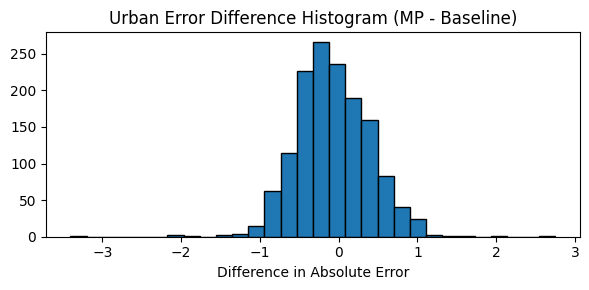

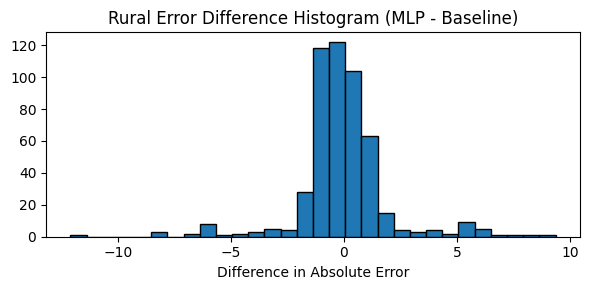

In [351]:
#Calculate the error terms based on validation set
urban_err_baseline = np.abs([urban_baseline_val] * len(y_val_u) - y_val_u)
urban_err_mlp = np.abs(urban_mlp_val_pred - y_val_u)

rural_err_baseline = np.abs([rural_baseline_val] * len(y_val_r) - y_val_r)
rural_err_mlp = np.abs(rural_mlp_val_pred - y_val_r)

# Calculate difference of errors btw models
urban_err_diff = urban_err_mlp - urban_err_baseline
rural_err_diff = rural_err_mlp - rural_err_baseline
# Plot histogram for error differences
#urban
plt.figure(figsize=(6,3))
plt.hist(urban_err_diff, bins=30, edgecolor='k')
plt.title("Urban Error Difference Histogram (MP - Baseline)")
plt.xlabel("Difference in Absolute Error")
plt.tight_layout()
plt.show()
#rural
plt.figure(figsize=(6,3))
plt.hist(rural_err_diff, bins=30, edgecolor='k')
plt.title("Rural Error Difference Histogram (MLP - Baseline)")
plt.xlabel("Difference in Absolute Error")
plt.tight_layout()
plt.show()

Although the distribution of error differences appears approximately normal, the Wilcoxon signed-rank test was used as a non-parametric and robust alternative that does not require a strict normality assumption.

In [352]:
# Wilcoxon test will be applied
from scipy.stats import wilcoxon
#urban
w_stat, p_wilcoxon = wilcoxon(urban_err_mlp, urban_err_baseline)
print(f"Urban Wilcoxon p-value: {p_wilcoxon:.3f}")
#rural
w_stat, p_wilcoxon = wilcoxon(rural_err_mlp, rural_err_baseline)
print(f"Rural Wilcoxon p-value: {p_wilcoxon:.3f}")

Urban Wilcoxon p-value: 0.000
Rural Wilcoxon p-value: 0.006


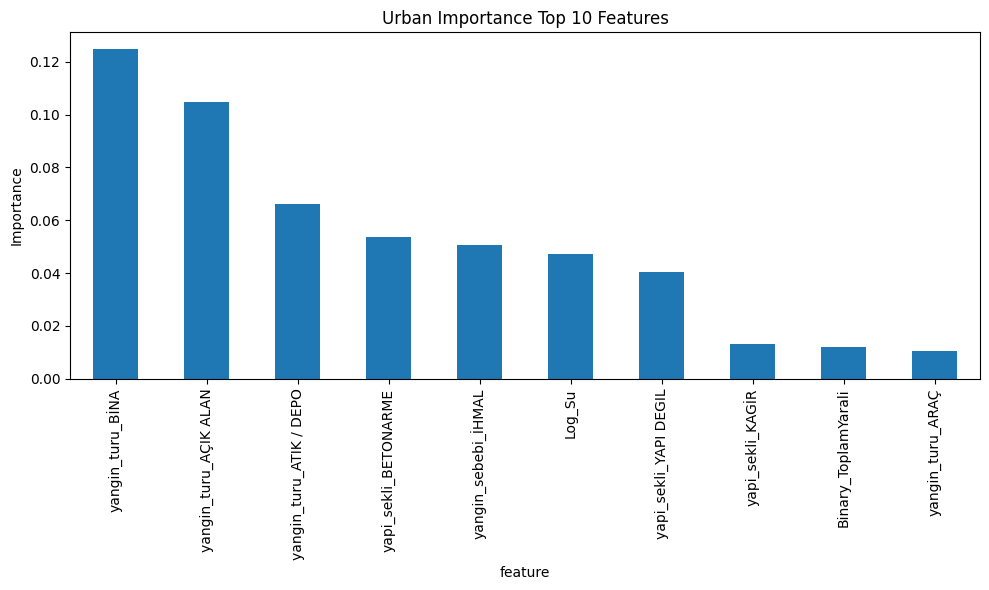

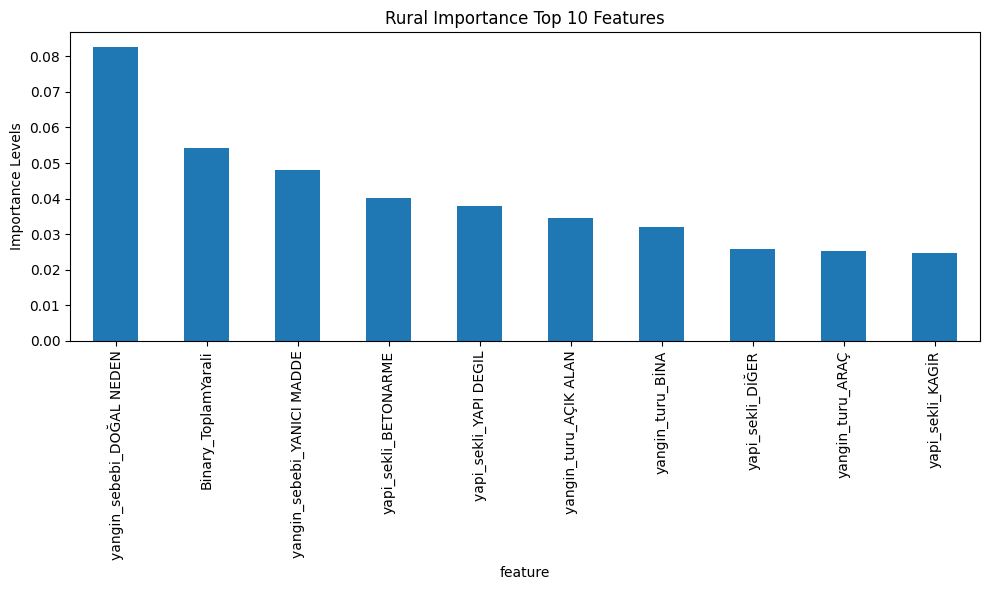

In [355]:
#permutation importance will be applied to the best performing model linear regression
from sklearn.inspection import permutation_importance
perm_urban_mlp = permutation_importance(mlp_search_u.best_estimator_, X_val_u, y_val_u, n_repeats=10, random_state=1908607)
importance_urban_mlp_df = pd.DataFrame({'feature': X_val_u.columns,'importance': perm_urban_mlp.importances_mean}).sort_values(by='importance', ascending=False).head(10)
#plot a bar chart to visualize the comparison of feature improtance
importance_urban_mlp_df.plot(kind='bar', x='feature', y='importance', figsize=(10, 6), legend=False)
plt.title("Urban Importance Top 10 Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("urban_perm_imp.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
# Compute permutation importance for rural
perm_rural_mlp = permutation_importance(mlp_search_r.best_estimator_, X_val_r, y_val_r, n_repeats=10, random_state=1908607)
importance_rural_mlp_df = pd.DataFrame({'feature': X_val_r.columns,'importance': perm_rural_mlp.importances_mean}).sort_values(by='importance', ascending=False).head(10)

#plot a bar chart to visualize the comparison of feature improtance
importance_rural_mlp_df.plot(kind='bar', x='feature', y='importance', figsize=(10, 6), legend=False)
plt.title("Rural Importance Top 10 Features")
plt.ylabel("Importance Levels")
plt.tight_layout()

plt.savefig("rural_perm_imp.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [354]:
# calculating percenatge to understand the imporatance better
urban_mlp_mae=mean_absolute_error(y_val_u, urban_mlp_val_pred)
rural_mlp_mae=mean_absolute_error(y_val_r, rural_mlp_val_pred)
importance_urban_mlp_df['urban percent'] = (importance_urban_mlp_df['importance'] / urban_mlp_mae) * 100
importance_rural_mlp_df['rural percent'] = (importance_rural_mlp_df['importance'] / rural_mlp_mae) * 100

# Show the updated tables
importance_urban_df_rounded = importance_urban_mlp_df.copy()
importance_urban_df_rounded['urban percent'] = importance_urban_df_rounded['urban percent'].round(2)

importance_rural_df_rounded = importance_rural_mlp_df.copy()
importance_rural_df_rounded['rural percent'] = importance_rural_df_rounded['rural percent'].round(2)

importance_urban_df_rounded, importance_rural_df_rounded

(                    feature  importance  urban percent
 6          yangin_turu_BİNA    0.124877           9.03
 5     yangin_turu_AÇIK ALAN    0.104913           7.59
 4   yangin_turu_ATIK / DEPO    0.066195           4.79
 19     yapi_sekli_BETONARME    0.053517           3.87
 17      yangin_sebebi_İHMAL    0.050550           3.66
 31                   Log_Su    0.047360           3.43
 22    yapi_sekli_YAPI DEGIL    0.040335           2.92
 21         yapi_sekli_KAGİR    0.013201           0.95
 29      Binary_ToplamYarali    0.011991           0.87
 3          yangin_turu_ARAÇ    0.010393           0.75,
                        feature  importance  rural percent
 12   yangin_sebebi_DOĞAL NEDEN    0.082611           1.89
 29         Binary_ToplamYarali    0.054251           1.24
 16  yangin_sebebi_YANICI MADDE    0.047936           1.10
 19        yapi_sekli_BETONARME    0.040287           0.92
 22       yapi_sekli_YAPI DEGIL    0.038030           0.87
 5        yangin_turu_AÇIK AL

Overall, it has been observed that in urban areas the fire type being a structure explains most of the variations in response times. Whereas in rural areas fire type being natural reasons covers most of the variations in the response times.In the urban context, fires occurring in buildings (yangin_turu_BİNA) account for over 9% of the total model error, followed by fires in open areas (yangin_turu_AÇIK ALAN, 7.6%). Building structure types such as reinforced concrete (yapi_sekli_BETONARME) are also among the most important features. In rural areas, natural fire causes (yangin_sebebi_DOĞAL NEDEN) have the highest importance, with injuries resulting from fires and the presence of flammable materials also among the top factors.